<p style="font-size:35px; font-weight:bold; text-align:center;">Forecasting Pedestrian Footfall in London's Retail Areas</p>


<p style="font-size:20px; font-weight:bold; text-align:center;">Dissertation Coding - Yihan Li</p>


## 1.0 | Load data

In [1]:
pip install pandas geopandas openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install xgboost

In [3]:
!pip install geopy

In [4]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import geopandas as gpd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Database interaction
import sqlite3 

# Geospatial operations
from shapely.geometry import Point 
from geopy.distance import geodesic

# Machine learning and clustering
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Date and time handling
from datetime import datetime

# File and OS operations
import os  # For operating system dependent functionality
import csv  # For handling CSV file operations

In [5]:
print(os.getcwd())

E:\YHL_dissertation


In [6]:
# Get the current working directory
current_dir = os.getcwd()

# Dynamically construct relative paths
sqlite_db_path = os.path.join(current_dir, 'sqlite', 'data.db')
footfall_data_path = os.path.join(current_dir, 'rawdata', 'footfall_data')

# Connect to SQLite database
conn = sqlite3.connect(sqlite_db_path)
cursor = conn.cursor()

# Clear tables
tables_to_clear = ['ff_install_notes', 'ff_locations', 'data_2018_01', 'data_2018_02', 'data_2018_03', 'data_2018_04', 'data_2018_05', 'data_2018_06', 'data_2018_07', 'data_2018_08', 'data_2018_09', 'data_2018_10', 'data_2018_11', 'data_2018_12', 'locations_within_greater_london', 'valid_locations_filtered', 'filtered_footfall']
for table in tables_to_clear:
    cursor.execute(f'DROP TABLE IF EXISTS {table}')

# Commit the changes and close the connection
conn.commit()
conn.close()

In [7]:
# Define the CSV files and corresponding table names
csv_files = {
    'ff_install_notes': os.path.join(footfall_data_path, 'ff_install_notes.csv'),
    'ff_locations': os.path.join(footfall_data_path, 'ff_locations.csv'),
    'data_2018_01': os.path.join(footfall_data_path, '2018-01.csv'),
    'data_2018_02': os.path.join(footfall_data_path, '2018-02.csv'),
    'data_2018_03': os.path.join(footfall_data_path, '2018-03.csv'),
    'data_2018_04': os.path.join(footfall_data_path, '2018-04.csv'),
    'data_2018_05': os.path.join(footfall_data_path, '2018-05.csv'),
    'data_2018_06': os.path.join(footfall_data_path, '2018-06.csv'),
    'data_2018_07': os.path.join(footfall_data_path, '2018-07.csv'),
    'data_2018_08': os.path.join(footfall_data_path, '2018-08.csv'),
    'data_2018_09': os.path.join(footfall_data_path, '2018-09.csv'),
    'data_2018_10': os.path.join(footfall_data_path, '2018-10.csv'),
    'data_2018_11': os.path.join(footfall_data_path, '2018-11.csv'),
    'data_2018_12': os.path.join(footfall_data_path, '2018-12.csv')
}

# Create table statements based on the provided CSV files
create_table_queries = {
    'ff_install_notes': '''
    CREATE TABLE IF NOT EXISTS ff_install_notes (
        device TEXT,
        location TEXT,
        start_date TEXT,
        end_date TEXT,
        height TEXT,
        depth TEXT,
        note TEXT
    )
    ''',
    'ff_locations': '''
    CREATE TABLE IF NOT EXISTS ff_locations (
        location TEXT,
        address TEXT,
        city TEXT,
        region TEXT,
        lat REAL,
        lon REAL,
        position TEXT,
        type TEXT
    )
    ''',
    'data_2018_01': '''
    CREATE TABLE IF NOT EXISTS data_2018_01 (
        timestamp TEXT,
        location TEXT,
        device TEXT,
        footfall INTEGER,
        imputed TEXT
    )
    ''',
    'data_2018_02': '''
    CREATE TABLE IF NOT EXISTS data_2018_02 (
        timestamp TEXT,
        location TEXT,
        device TEXT,
        footfall INTEGER,
        imputed TEXT
    )
    ''',
    'data_2018_03': '''
    CREATE TABLE IF NOT EXISTS data_2018_03 (
        timestamp TEXT,
        location TEXT,
        device TEXT,
        footfall INTEGER,
        imputed TEXT
    )
    ''',
    'data_2018_04': '''
    CREATE TABLE IF NOT EXISTS data_2018_04 (
        timestamp TEXT,
        location TEXT,
        device TEXT,
        footfall INTEGER,
        imputed TEXT
    )
    ''',
    'data_2018_05': '''
    CREATE TABLE IF NOT EXISTS data_2018_05 (
        timestamp TEXT,
        location TEXT,
        device TEXT,
        footfall INTEGER,
        imputed TEXT
    )
    ''',
    'data_2018_06': '''
    CREATE TABLE IF NOT EXISTS data_2018_06 (
        timestamp TEXT,
        location TEXT,
        device TEXT,
        footfall INTEGER,
        imputed TEXT
    )
    ''',
    'data_2018_07': '''
    CREATE TABLE IF NOT EXISTS data_2018_07 (
        timestamp TEXT,
        location TEXT,
        device TEXT,
        footfall INTEGER,
        imputed TEXT
    )
    ''',
    'data_2018_08': '''
    CREATE TABLE IF NOT EXISTS data_2018_08 (
        timestamp TEXT,
        location TEXT,
        device TEXT,
        footfall INTEGER,
        imputed TEXT
    )
    ''',
    'data_2018_09': '''
    CREATE TABLE IF NOT EXISTS data_2018_09 (
        timestamp TEXT,
        location TEXT,
        device TEXT,
        footfall INTEGER,
        imputed TEXT
    )
    ''',
    'data_2018_10': '''
    CREATE TABLE IF NOT EXISTS data_2018_10 (
        timestamp TEXT,
        location TEXT,
        device TEXT,
        footfall INTEGER,
        imputed TEXT
    )
    ''',
    'data_2018_11': '''
    CREATE TABLE IF NOT EXISTS data_2018_11 (
        timestamp TEXT,
        location TEXT,
        device TEXT,
        footfall INTEGER,
        imputed TEXT
    )
    ''',
    'data_2018_12': '''
    CREATE TABLE IF NOT EXISTS data_2018_12 (
        timestamp TEXT,
        location TEXT,
        device TEXT,
        footfall INTEGER,
        imputed TEXT
    )
    '''
}

# Connect to SQLite database
conn = sqlite3.connect(sqlite_db_path)
cursor = conn.cursor()

# Create all the tables
for table, create_query in create_table_queries.items():
    cursor.execute(create_query)

# Read each CSV file and insert the data into the corresponding table
for table, file_path in csv_files.items():
    with open(file_path, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        headers = next(reader)  # Get the header row
        insert_query = f'INSERT INTO {table} ({", ".join(headers)}) VALUES ({", ".join(["?"] * len(headers))})'
        for row in reader:
            cursor.execute(insert_query, row)

# Commit the transactions
conn.commit()

# Close the connection
conn.close()

## 2.0 | Data cleaning

### 2.1 Remove sensors outside Greater London

In [8]:
# Get the current working directory
current_dir = os.getcwd()

# Dynamically construct relative paths
sqlite_db_path = os.path.join(current_dir, 'sqlite', 'data.db')
greater_london_boundary_path = os.path.join(current_dir, 'rawdata', 'Greater_London.geojson')
retail_boundaries_gpkg_path = os.path.join(current_dir, 'rawdata', 'Retail_Boundaries_UK.gpkg')
footfall_data_path = os.path.join(current_dir, 'rawdata', 'footfall_data')

# Connect to SQLite database
conn = sqlite3.connect(sqlite_db_path)

# Load sensor location data from SQLite
df_locations = pd.read_sql('SELECT * FROM ff_locations', conn)

# Load Greater London boundary data
greater_london_boundary = gpd.read_file(greater_london_boundary_path)

In [9]:
# Convert sensor locations to GeoDataFrame
geometry = [Point(xy) for xy in zip(df_locations['lon'], df_locations['lat'])]
gdf_locations = gpd.GeoDataFrame(df_locations, geometry=geometry, crs="EPSG:4326")

# Clip sensor locations to Greater London boundary
gdf_locations_greater_london = gpd.sjoin(gdf_locations, greater_london_boundary, how='inner', predicate='within')

# Retain only relevant columns
gdf_locations_greater_london = gdf_locations_greater_london[['location', 'lat', 'lon', 'geometry']]

# Save the geometry data for plotting
gdf_locations_greater_london_plot = gdf_locations_greater_london.copy()
# Convert geometry to WKT format
gdf_locations_greater_london['geometry'] = gdf_locations_greater_london['geometry'].apply(lambda x: x.wkt)

# Get valid sensor locations within Greater London
valid_locations_greater_london = gdf_locations_greater_london['location'].unique()

# Save filtered locations to SQLite
gdf_locations_greater_london.to_sql('locations_within_greater_london', conn, if_exists='replace', index=False)

# Close the database connection
conn.close()

C:\Users\MJ\AppData\Local\Temp\ipykernel_18524\121867341.py:14: UserWarning: Geometry column does not contain geometry.
  gdf_locations_greater_london['geometry'] = gdf_locations_greater_london['geometry'].apply(lambda x: x.wkt)


In [10]:
# Get the current working directory
current_dir = os.getcwd()

# Dynamically construct relative paths
sqlite_db_path = os.path.join(current_dir, 'sqlite', 'data.db')
greater_london_boundary_path = os.path.join(current_dir, 'rawdata', 'Greater_London.geojson')

# Connect to SQLite database
conn = sqlite3.connect(sqlite_db_path)

# Load sensor location data from SQLite
df_locations = pd.read_sql('SELECT * FROM ff_locations', conn)

# Load Greater London boundary data
greater_london_boundary = gpd.read_file(greater_london_boundary_path)

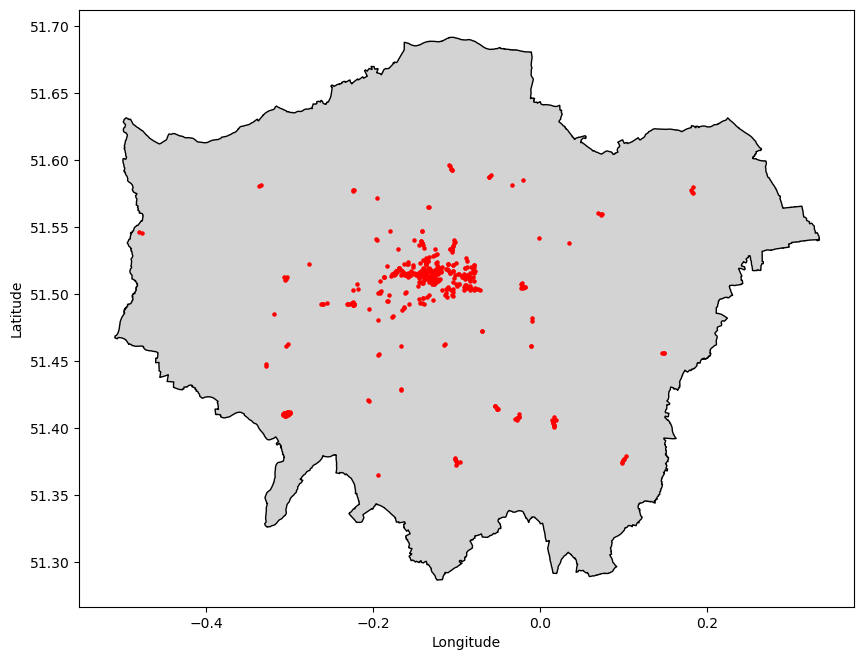

In [11]:
# Plot the map of sensor locations within Greater London Boundaries
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the Greater London boundary as a light grey area
greater_london_boundary.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot the sensor locations within Greater London boundaries
gdf_locations_greater_london_plot.plot(ax=ax, color='red', markersize=5)

# Add title and labels for clarity
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the figure to a specified directory as a .jpg file before showing it
output_dir = './figures'
if not os.path.exists(output_dir):  # Check if the directory exists
    os.makedirs(output_dir)  # Create directory if it does not exist
fig.savefig(os.path.join(output_dir, 'Sensor_Locations_within_Greater_London_Boundaries.PNG'))

# Display the plot
plt.show()

# Close the database connection
conn.close()

### 2.2 Remove sensors with insufficient actived time

In [12]:
from datetime import datetime

# Connect to SQLite database
conn = sqlite3.connect(sqlite_db_path)

# Load sensor installation data from SQLite
df_install_notes = pd.read_sql('SELECT * FROM ff_install_notes', conn)

# Filter sensors within Greater London and remove unnecessary columns
df_install_notes_greater_london = df_install_notes[df_install_notes['location'].isin(valid_locations_greater_london)]
df_install_notes_greater_london = df_install_notes_greater_london[['device', 'location', 'start_date', 'end_date']]

# Drop rows with any NaN values in 'start_date'
df_install_notes_greater_london.dropna(subset=['start_date'], inplace=True)

print(df_install_notes_greater_london)

     device location  start_date    end_date
0         5       14  2015-10-13  2016-03-20
1         9       89  2016-01-05  2016-02-02
2        10       12  2015-07-01  2018-01-31
3        12        2  2015-07-01  2017-02-14
4        14       60  2015-07-01  2015-08-21
...     ...      ...         ...         ...
1417   2074     1134  2018-05-25  2019-07-31
1418   2076     1115  2018-04-05  2020-03-16
1421   2080      186  2018-03-21  2019-11-22
1425   2084     1116  2018-04-03  2020-03-16
1427   2088     1136  2018-05-22  2019-07-31

[545 rows x 4 columns]


In [13]:
# Convert start_date and end_date to datetime
df_install_notes_greater_london['start_date'] = pd.to_datetime(df_install_notes_greater_london['start_date'])
df_install_notes_greater_london['end_date'] = pd.to_datetime(df_install_notes_greater_london['end_date'], errors='coerce')

In [14]:
# Calculate usage time within 2018
df_install_notes_greater_london['start_2018'] = df_install_notes_greater_london['start_date'].apply(lambda x: max(x, datetime(2018, 1, 1)))
df_install_notes_greater_london['end_2018'] = df_install_notes_greater_london['end_date'].apply(lambda x: min(x, datetime(2018, 12, 31)) if pd.notnull(x) else datetime(2018, 12, 31))
df_install_notes_greater_london['usage_days_2018'] = (df_install_notes_greater_london['end_2018'] - df_install_notes_greater_london['start_2018']).dt.days
df_install_notes_greater_london = df_install_notes_greater_london[df_install_notes_greater_london['usage_days_2018'] > 0]

# Sort sensors by usage days in 2018
df_install_notes_greater_london_sorted = df_install_notes_greater_london.sort_values(by='usage_days_2018', ascending=False)
print(df_install_notes_greater_london_sorted)

     device location start_date   end_date start_2018   end_2018  \
762    1355        6 2016-10-27        NaT 2018-01-01 2018-12-31   
1231   1823      939 2017-10-26 2020-03-16 2018-01-01 2018-12-31   
1220   1813     1016 2017-09-15 2020-03-16 2018-01-01 2018-12-31   
738    1327      567 2016-11-25 2020-01-31 2018-01-01 2018-12-31   
742    1331      846 2017-04-05 2020-03-16 2018-01-01 2018-12-31   
...     ...      ...        ...        ...        ...        ...   
258     845      156 2017-08-25 2018-01-15 2018-01-01 2018-01-15   
1236   1828     1074 2017-11-17 2018-01-15 2018-01-01 2018-01-15   
763    1356     1022 2018-11-23 2018-12-04 2018-11-23 2018-12-04   
1283   1881      126 2017-12-06 2018-01-12 2018-01-01 2018-01-12   
454    1016       57 2016-07-18 2018-01-12 2018-01-01 2018-01-12   

      usage_days_2018  
762               364  
1231              364  
1220              364  
738               364  
742               364  
...               ...  
258            

In [15]:
# Calculate statistical data
stats = df_install_notes_greater_london_sorted['usage_days_2018'].describe(percentiles=[.25, .5, .75])
print(stats)

count    344.000000
mean     293.377907
std      108.396030
min       11.000000
25%      222.000000
50%      364.000000
75%      364.000000
max      364.000000
Name: usage_days_2018, dtype: float64


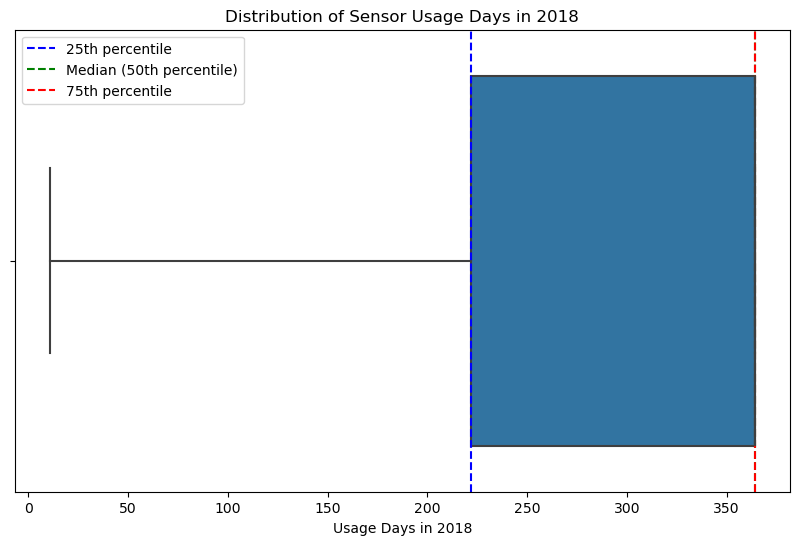

In [16]:
# Plot the distribution of usage days
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_install_notes_greater_london_sorted['usage_days_2018'])
plt.title('Distribution of Sensor Usage Days in 2018')
plt.xlabel('Usage Days in 2018')
plt.axvline(stats['25%'], color='blue', linestyle='--', label='25th percentile')
plt.axvline(stats['50%'], color='green', linestyle='--', label='Median (50th percentile)')
plt.axvline(stats['75%'], color='red', linestyle='--', label='75th percentile')
plt.legend()
plt.show()

In [17]:
# Set a threshold based on statistical data to filter sensors
threshold_days = stats['25%']  # Using the 25th percentile as the threshold

# Filter sensors based on their usage days in 2018
df_install_notes_filtered = df_install_notes_greater_london_sorted[
    df_install_notes_greater_london_sorted['usage_days_2018'] >= threshold_days
]

# Get the unique filtered locations and devices
valid_locations_filtered = df_install_notes_filtered['location'].unique()
valid_devices_filtered = df_install_notes_filtered['device'].unique()

# Display the filtered locations and devices
print("Filtered locations based on usage in 2018:", valid_locations_filtered)
print("Filtered devices based on usage in 2018:", valid_devices_filtered)

# Convert the filtered locations and devices to DataFrames
valid_locations_filtered_df = pd.DataFrame(valid_locations_filtered, columns=['location'])
valid_devices_filtered_df = pd.DataFrame(valid_devices_filtered, columns=['device'])

# Save the filtered locations and devices to the SQLite database
conn = sqlite3.connect(sqlite_db_path)  # Reopen or ensure the connection to the database
valid_locations_filtered_df.to_sql('valid_locations_filtered', conn, if_exists='replace', index=False)
valid_devices_filtered_df.to_sql('valid_devices_filtered', conn, if_exists='replace', index=False)

# Close the database connection
conn.close()

Filtered locations based on usage in 2018: ['6' '939' '1016' '567' '846' '112' '853' '7' '573' '145' '575' '743'
 '800' '1015' '459' '498' '430' '174' '497' '91' '503' '155' '5' '499'
 '501' '113' '1007' '571' '493' '78' '87' '643' '599' '829' '683' '711'
 '713' '765' '502' '778' '750' '682' '687' '953' '734' '1076' '744' '121'
 '330' '89' '114' '146' '119' '117' '948' '357' '585' '1075' '584' '1026'
 '492' '994' '455' '880' '123' '130' '124' '150' '905' '707' '882' '852'
 '212' '756' '759' '127' '736' '782' '875' '38' '783' '434' '780' '589'
 '583' '88' '217' '53' '116' '881' '639' '495' '432' '62' '947' '574'
 '854' '810' '1013' '851' '159' '1011' '617' '793' '658' '313' '709' '952'
 '751' '694' '1012' '92' '805' '988' '1014' '710' '1037' '904' '661' '995'
 '745' '663' '122' '282' '39' '329' '568' '879' '485' '587' '1077' '996'
 '336' '337' '308' '983' '642' '312' '310' '314' '878' '300' '328' '986'
 '320' '483' '326' '3' '245' '111' '989' '1078' '457' '98' '806' '535'
 '108' '152' '

In [18]:
# Group the DataFrame by 'location' and count the number of unique 'device' entries for each location
unique_devices_per_location = df_install_notes_filtered.groupby('location')['device'].nunique()

# Identify locations that are associated with more than one device
non_unique_locations = unique_devices_per_location[unique_devices_per_location > 1]

# Check if any location is associated with multiple devices
if non_unique_locations.empty:
    print("All locations have a unique device associated with them.")
else:
    print("Locations with multiple devices associated:")
    print(non_unique_locations)

All locations have a unique device associated with them.


## 3.0 | Data Preprocessing

### 3.1 Data Aggregation

In [19]:
# Get the current working directory
current_dir = os.getcwd()

# Dynamically construct relative paths
sqlite_db_path = os.path.join(current_dir, 'sqlite', 'data.db')
footfall_data_path = os.path.join(current_dir, 'rawdata', 'footfall_data')

# Connect to SQLite database
conn = sqlite3.connect(sqlite_db_path)

# Load valid locations
valid_locations_filtered = pd.read_sql('SELECT * FROM valid_locations_filtered', conn)['location'].tolist()

# Load and filter footfall data
footfall_files = [os.path.join(footfall_data_path, f) for f in os.listdir(footfall_data_path) if f.endswith('.csv')]
df_footfall = pd.DataFrame()

for file in footfall_files:
    df_temp = pd.read_csv(file)
    
    # Ensure 'location' column exists
    if 'location' not in df_temp.columns:
        raise KeyError(f"No 'location' column found in file {file}")
    
    # Ensure 'timestamp' and 'footfall' columns exist
    required_columns = ['timestamp', 'location', 'device', 'footfall']
    if not all(column in df_temp.columns for column in required_columns):
        print(f"Skipping file {file} because it does not contain required columns.")
        continue
    
    # Convert 'location' column to string
    df_temp['location'] = df_temp['location'].astype(str)
    
    # Filter data based on valid location IDs
    df_temp_filtered = df_temp[df_temp['location'].isin(valid_locations_filtered)].copy()
    
    # Drop rows with any NaN values
    df_temp_filtered.dropna(subset=['timestamp', 'location', 'device', 'footfall'], inplace=True)
    
    # Check the number of rows after filtering and dropping NaN
    print(f"Filtered rows in {file}: {len(df_temp_filtered)}")
    
    df_footfall = pd.concat([df_footfall, df_temp_filtered])

# Check if 'timestamp' column exists and convert to datetime
if 'timestamp' in df_footfall.columns:
    df_footfall['timestamp'] = pd.to_datetime(df_footfall['timestamp'])
else:
    raise KeyError("No 'timestamp' column found in the footfall data")

# Ensure columns are consistent
df_footfall = df_footfall[['timestamp', 'location', 'device', 'footfall']]

# Set timestamp as index
df_footfall.set_index('timestamp', inplace=True)

# Aggregate data by hour
hourly_footfall = df_footfall['footfall'].resample('H').mean()

# Aggregate data by day
daily_footfall = df_footfall['footfall'].resample('D').mean()

# Print the first few rows of the final dataframe
print(df_footfall.head())
print(f"Total rows in footfall data: {len(df_footfall)}")

# Display aggregated data
print("Hourly footfall data:")
print(hourly_footfall.head())
print("\nDaily footfall data:")
print(daily_footfall.head())

# Save the filtered and cleaned footfall data to SQLite
df_footfall.to_sql('filtered_footfall', conn, if_exists='replace')
hourly_footfall.to_sql('hourly_footfall', conn, if_exists='replace')
daily_footfall.to_sql('daily_footfall', conn, if_exists='replace')

# Close the connection
conn.close()

Filtered rows in E:\YHL_dissertation\rawdata\footfall_data\2018-01.csv: 1881792
Filtered rows in E:\YHL_dissertation\rawdata\footfall_data\2018-02.csv: 1714464
Filtered rows in E:\YHL_dissertation\rawdata\footfall_data\2018-03.csv: 1829952
Filtered rows in E:\YHL_dissertation\rawdata\footfall_data\2018-04.csv: 1720800
Filtered rows in E:\YHL_dissertation\rawdata\footfall_data\2018-05.csv: 1639872
Filtered rows in E:\YHL_dissertation\rawdata\footfall_data\2018-06.csv: 1656000
Filtered rows in E:\YHL_dissertation\rawdata\footfall_data\2018-07.csv: 1699200
Filtered rows in E:\YHL_dissertation\rawdata\footfall_data\2018-08.csv: 1444608
Filtered rows in E:\YHL_dissertation\rawdata\footfall_data\2018-09.csv: 1687968
Filtered rows in E:\YHL_dissertation\rawdata\footfall_data\2018-10.csv: 1890720
Filtered rows in E:\YHL_dissertation\rawdata\footfall_data\2018-11.csv: 1786176
Filtered rows in E:\YHL_dissertation\rawdata\footfall_data\2018-12.csv: 1859616
Skipping file E:\YHL_dissertation\rawdat

### 3.2 Data Description

In [20]:
conn = sqlite3.connect(sqlite_db_path)
df_footfall = pd.read_sql('SELECT * FROM filtered_footfall', conn, parse_dates=['timestamp'], index_col='timestamp')
hourly_footfall = pd.read_sql('SELECT * FROM hourly_footfall', conn, parse_dates=['timestamp'], index_col='timestamp')
daily_footfall = pd.read_sql('SELECT * FROM daily_footfall', conn, parse_dates=['timestamp'], index_col='timestamp')

# Describe the cleaned footfall data
hourly_description = hourly_footfall.describe()
daily_description = daily_footfall.describe()

In [21]:
# Describe the cleaned footfall data
print("Hourly footfall data description:")
print(hourly_description)
print("\nDaily footfall data description:")
print(daily_description)

Hourly footfall data description:
          footfall
count  8760.000000
mean     48.571621
std      34.119838
min       1.527913
25%      14.677534
50%      44.280596
75%      77.695322
max     133.784689

Daily footfall data description:
         footfall
count  365.000000
mean    48.571621
std      7.411869
min     13.496758
25%     44.579483
50%     50.321561
75%     53.699855
max     64.204542


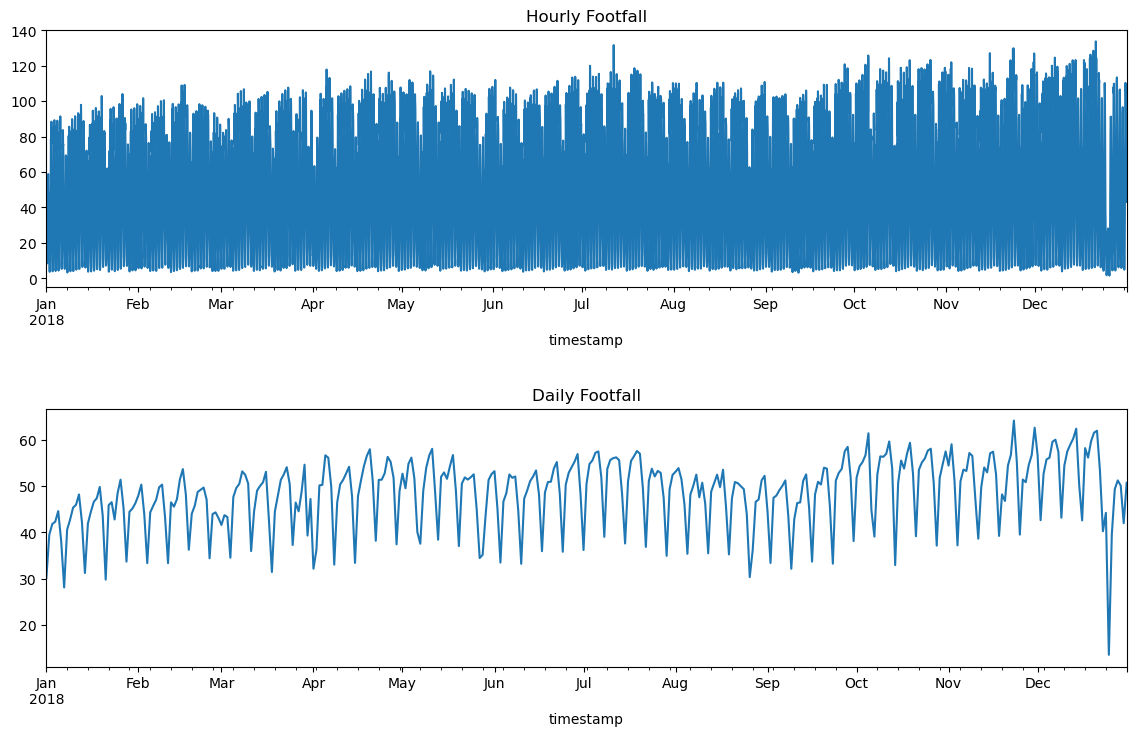

In [22]:
# Plot time series charts for hourly and daily footfall
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
hourly_footfall['footfall'].plot(ax=ax[0], title='Hourly Footfall')
daily_footfall['footfall'].plot(ax=ax[1], title='Daily Footfall')

# Adjust layout to ensure there's space between the two plots
plt.tight_layout(pad=3.0)

plt.show()

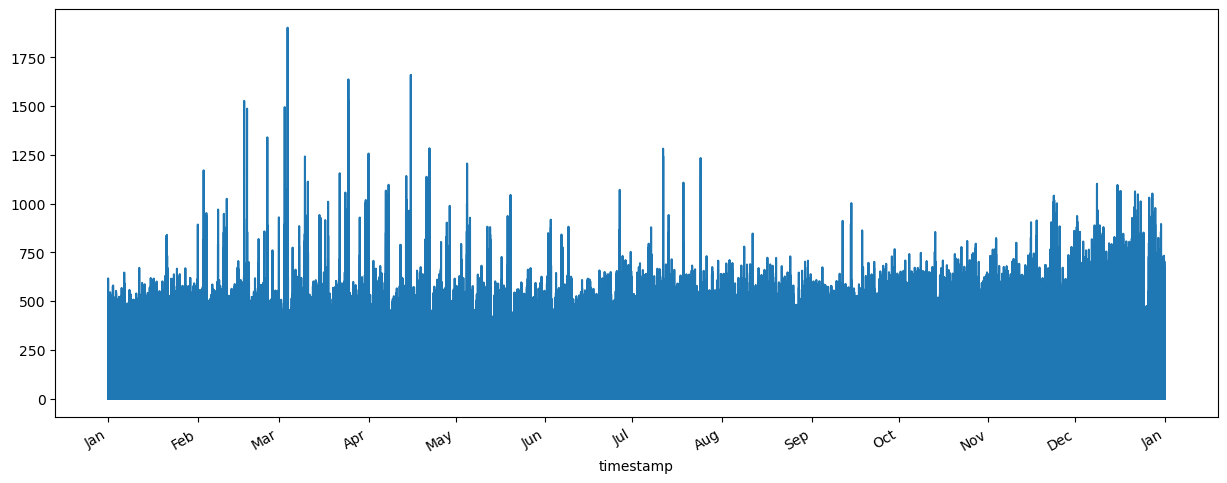

In [23]:
import matplotlib.dates as mdates

# Plot time series chart for footfall data
fig, ax = plt.subplots(figsize=(15, 6))
df_footfall['footfall'].plot(ax=ax)

# Remove the title
ax.set_title('')

# Format the x-axis to show only the month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # '%b' formats the date as the abbreviated month name

# Set x-axis major locator to be monthly
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Save the plot to a file before displaying it
fig.savefig('./figures/footfall_over_time.png', bbox_inches='tight')

# Show the plot
plt.show()

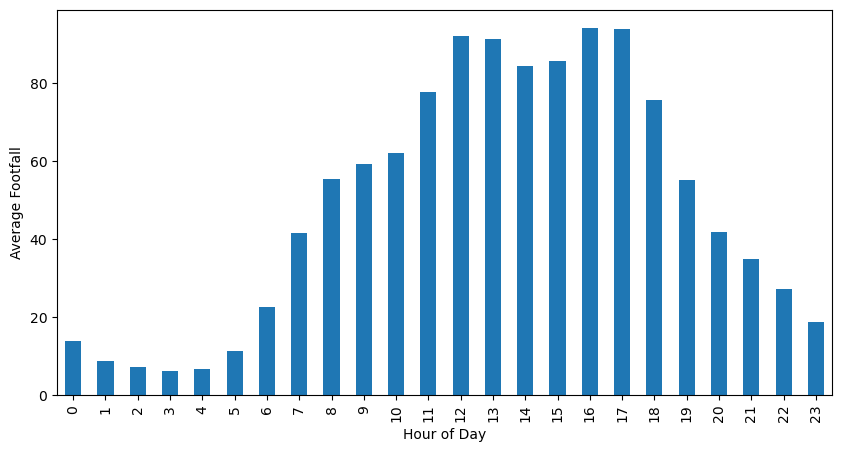

In [24]:
# Analyze daily patterns
df_footfall['hour'] = df_footfall.index.hour
hourly_pattern = df_footfall.groupby('hour')['footfall'].mean()

# Plot daily patterns
fig, ax = plt.subplots(figsize=(10, 5))
hourly_pattern.plot(kind='bar', ax=ax)

# Remove the title and labels
ax.set_title('')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Average Footfall')

# Save the plot to a file before displaying it
fig.savefig('./figures/average_footfall_by_hour_of_day.png', bbox_inches='tight')

# Show the plot
plt.show()

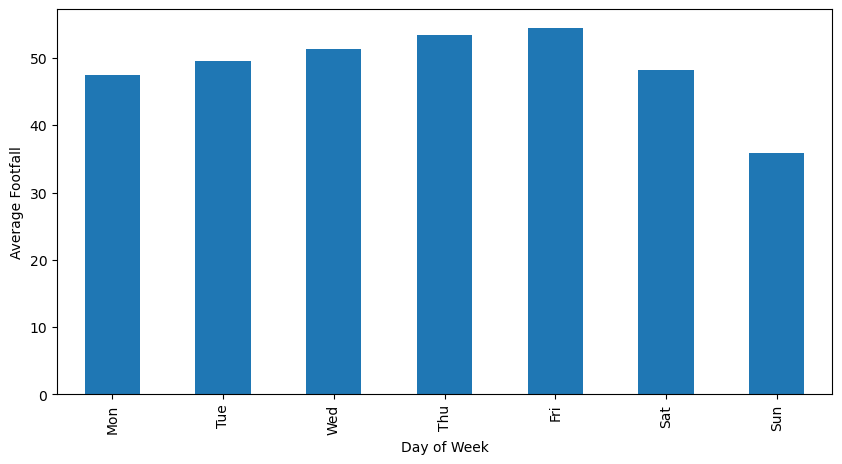

In [25]:
# Analyze weekly patterns
df_footfall['day_of_week'] = df_footfall.index.dayofweek
weekly_pattern = df_footfall.groupby('day_of_week')['footfall'].mean()

# Plot weekly patterns
fig, ax = plt.subplots(figsize=(10, 5))
weekly_pattern.plot(kind='bar', ax=ax)

# Remove the title and labels
ax.set_title('')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Average Footfall')

# Customize x-ticks to display day names
ax.set_xticks(range(7))
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Save the plot to a file before displaying it
fig.savefig('./figures/average_footfall_by_day_of_week.png', bbox_inches='tight')

# Show the plot
plt.show()

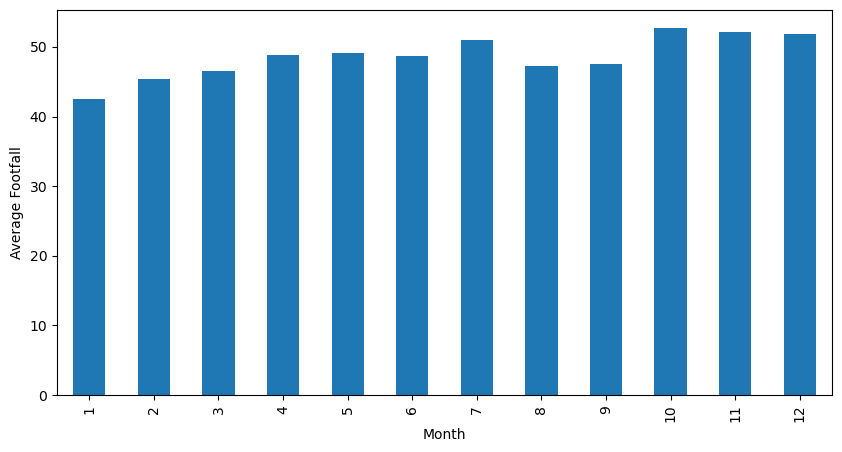

In [26]:
# Analyze monthly patterns
df_footfall['month'] = df_footfall.index.month
monthly_pattern = df_footfall.groupby('month')['footfall'].mean()

# Plot monthly patterns
fig, ax = plt.subplots(figsize=(10, 5))
monthly_pattern.plot(kind='bar', ax=ax)

# Remove the title and labels
ax.set_title('')
ax.set_xlabel('Month')
ax.set_ylabel('Average Footfall')

# Save the plot to a file before displaying it
fig.savefig('./figures/average_footfall_by_month.png', bbox_inches='tight')

# Show the plot
plt.show()

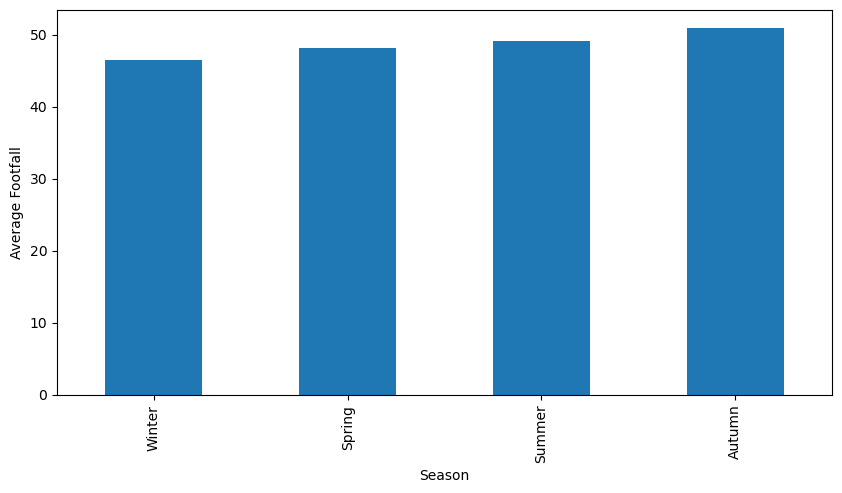

In [27]:
# Analyze seasonal patterns
df_footfall['season'] = df_footfall['month'] % 12 // 3 + 1
seasonal_pattern = df_footfall.groupby('season')['footfall'].mean()

# Plot seasonal patterns
fig, ax = plt.subplots(figsize=(10, 5))
seasonal_pattern.plot(kind='bar', ax=ax)

# Remove the title and labels
ax.set_title('')
ax.set_xlabel('Season')
ax.set_ylabel('Average Footfall')
ax.set_xticks(ticks=range(4))  # Adjust to have four ticks
ax.set_xticklabels(['Winter', 'Spring', 'Summer', 'Autumn'])

# Save the plot to a file before displaying it
fig.savefig('./figures/average_footfall_by_season.png', bbox_inches='tight')

# Show the plot
plt.show()

In [28]:
# Save aggregated data and patterns to SQLite
hourly_pattern.to_sql('hourly_pattern', conn, if_exists='replace')
weekly_pattern.to_sql('weekly_pattern', conn, if_exists='replace')
monthly_pattern.to_sql('monthly_pattern', conn, if_exists='replace')
seasonal_pattern.to_sql('seasonal_pattern', conn, if_exists='replace')

conn.close()

## 4.0 | Identify the Retail Area with the Highest Sensor Density

### 4.1 Load Filtered Sensor Locations

In [29]:
# Paths
current_dir = os.getcwd()
sqlite_db_path = os.path.join(current_dir, 'sqlite', 'data.db')
greater_london_boundary_path = os.path.join(current_dir, 'rawdata', 'Greater_London.geojson')
retail_boundaries_path = os.path.join(current_dir, 'rawdata', 'Retail_Boundaries_UK.gpkg')

conn = sqlite3.connect(sqlite_db_path)

# Load locations data from SQLite
df_locations_greater_london = pd.read_sql('SELECT * FROM locations_within_greater_london', conn)

# Load valid locations and devices data
valid_locations_filtered_df = pd.read_sql('SELECT * FROM valid_locations_filtered', conn)

# Filter df_locations_greater_london by valid locations and devices
df_filtered_greater_london = df_locations_greater_london[
    df_locations_greater_london['location'].isin(valid_locations_filtered_df['location'])
]

# Convert 'geometry' column back to GeoDataFrame format if needed
df_filtered_greater_london['geometry'] = gpd.GeoSeries.from_wkt(df_filtered_greater_london['geometry'])
gdf_filtered_greater_london = gpd.GeoDataFrame(df_filtered_greater_london, geometry='geometry', crs="EPSG:4326")

print("Filtered Greater London locations with valid sensors:")
print(gdf_filtered_greater_london.head())

Filtered Greater London locations with valid sensors:
   location       lat      lon                   geometry
3        11  51.51684 -0.12749  POINT (-0.12749 51.51684)
5        13  51.51738 -0.12013  POINT (-0.12013 51.51738)
9         3  51.52128 -0.12370   POINT (-0.1237 51.52128)
18       38  51.37525 -0.10120   POINT (-0.1012 51.37525)
23       57  51.51742 -0.11925  POINT (-0.11925 51.51742)


C:\Users\MJ\AppData\Local\Temp\ipykernel_18524\2564166198.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_greater_london['geometry'] = gpd.GeoSeries.from_wkt(df_filtered_greater_london['geometry'])


### 4.2 Map the distribution of Sensor Locations

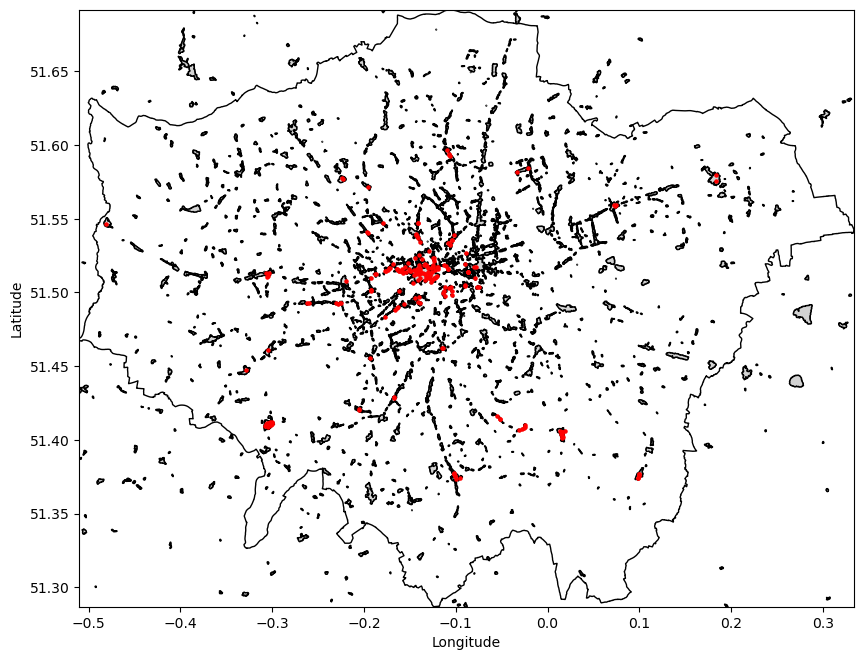

In [30]:
# Load Greater London Boundary for proper map limits
gdf_greater_london_boundary = gpd.read_file(greater_london_boundary_path)

# Load Retail Boundaries Data
gdf_retail_boundaries = gpd.read_file(retail_boundaries_path)

# Reproject retail boundaries to match sensor locations CRS
gdf_retail_boundaries = gdf_retail_boundaries.to_crs("EPSG:4326")

# Spatial Join with Retail Boundaries using filtered sensor data
gdf_sensors_retail = gpd.sjoin(gdf_filtered_greater_london, gdf_retail_boundaries, how='inner', predicate='within')

# Plot the map with Greater London boundary and retail boundaries
fig, ax = plt.subplots(figsize=(10, 10))
gdf_greater_london_boundary.plot(ax=ax, color='none', edgecolor='black')  # Plot Greater London boundary
gdf_retail_boundaries.plot(ax=ax, color='lightgrey', edgecolor='black')  # Plot retail boundaries within Greater London
gdf_sensors_retail.plot(ax=ax, color='red', markersize=5)  # Plot sensors within Greater London and retail boundaries

# Set map limits using Greater London boundary
ax.set_xlim(gdf_greater_london_boundary.total_bounds[[0, 2]])  # Set longitude limits
ax.set_ylim(gdf_greater_london_boundary.total_bounds[[1, 3]])  # Set latitude limits

ax.set_title('')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Save the plot as an image file
fig.savefig('./figures/sensor_locations_within_greater_london_and_retail_boundaries.png', bbox_inches='tight')

# Show the plot with the title removed
plt.show()

# Close the database connection
conn.close()

### 4.3 Calculate Sensor Density and Identify the Highest Density Area

In [31]:
conn = sqlite3.connect(sqlite_db_path)

gdf_retail_boundaries = gpd.read_file(retail_boundaries_path)

# Display the first few rows of the dataframe to inspect the data
print(gdf_retail_boundaries.head())

        RC_ID                                            RC_Name  \
0  RC_EW_1004  Melton Road; Belgrave; Leicester (East Midland...   
1   RC_EW_101  Hessle Road; Dairycoates; City of Kingston upo...   
2  RC_EW_1010  Belgrave Road; Belgrave; Leicester (East Midla...   
3  RC_EW_1013  Beaumont Shopping Centre; Leicester (East Midl...   
4  RC_EW_1014      Leicester; Leicester (East Midlands; England)   

      Classification  Country                 Region_NM  H3_count  Retail_N  \
0       Local Centre  England             East Midlands      19.0     141.0   
1    District Centre  England  Yorkshire and The Humber     131.0     252.0   
2    District Centre  England             East Midlands      43.0     216.0   
3  Large Retail Park  England             East Midlands      87.0      48.0   
4  Major Town Centre  England             East Midlands     268.0    1431.0   

   Area_km2                                           geometry  
0  0.036693  POLYGON ((459669.06 306613.671, 459673

In [32]:
# Check the unique classifications
if 'Classification' in gdf_retail_boundaries.columns:
    classifications = gdf_retail_boundaries['Classification'].unique()
    print("Unique classifications in the retail boundaries data:", classifications)
else:
    print("No 'classification' column found in the retail boundaries data.")

Unique classifications in the retail boundaries data: ['Local Centre' 'District Centre' 'Large Retail Park' 'Major Town Centre'
 'Regional Centre' 'Town Centre' 'Market Town' 'Large Shopping Centre'
 'Small Shopping Centre' 'Small Retail Park' 'Small Local Centre']


In [33]:
# Calculate the number of valid devices filtered
valid_devices_filtered_count = len(valid_devices_filtered)

# Print the number of valid devices filtered
print("Number of valid devices filtered:", valid_devices_filtered_count)

Number of valid devices filtered: 260


In [34]:
# Calculate Sensor Density for Each Retail Area
sensor_density = gdf_sensors_retail.groupby('RC_ID').size().reset_index(name='sensor_count')

# Merge with retail boundaries to get RC_Name and Classification
sensor_density = sensor_density.merge(gdf_retail_boundaries[['RC_ID', 'RC_Name', 'Classification']], on='RC_ID', how='left')

# Check if there are any results
if sensor_density.empty:
    print("No sensors found within any retail areas.")
else:
    # Identify Retail Area with Highest Sensor Density
    highest_density_area = sensor_density.sort_values(by='sensor_count', ascending=False).iloc[0]
    highest_density_rc_id = highest_density_area['RC_ID']

    print("Retail area with highest sensor density:")
    print(highest_density_area[['RC_ID', 'RC_Name', 'Classification', 'sensor_count']])

Retail area with highest sensor density:
RC_ID                                   RC_EW_1956
RC_Name           London; London (London; England)
Classification                     Regional Centre
sensor_count                                    63
Name: 19, dtype: object


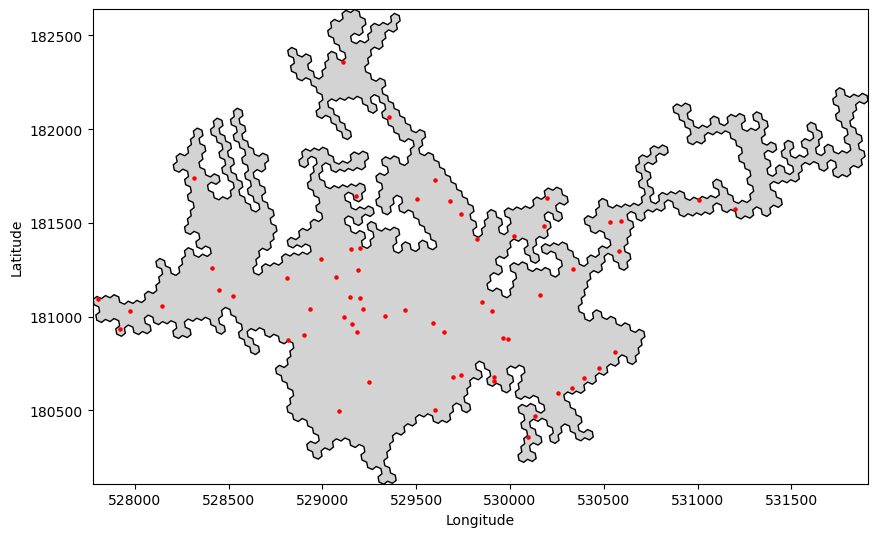

In [35]:
# Visualize the highest density retail area
gdf_highest_density_area = gdf_retail_boundaries[gdf_retail_boundaries['RC_ID'] == highest_density_rc_id]
gdf_sensors_highest_density = gdf_sensors_retail[gdf_sensors_retail['RC_ID'] == highest_density_rc_id]

gdf_sensors_highest_density = gdf_sensors_highest_density.to_crs(gdf_highest_density_area.crs)

fig, ax = plt.subplots(figsize=(10, 10))
gdf_highest_density_area.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_sensors_highest_density.plot(ax=ax, color='red', markersize=5)
ax.set_xlim(gdf_highest_density_area.total_bounds[[0, 2]])
ax.set_ylim(gdf_highest_density_area.total_bounds[[1, 3]])
ax.set_title('')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Save the plot as an image file
fig.savefig('./figures/sensor_locations_within_highest_density_retail_area.png', bbox_inches='tight')

# Show the plot
plt.show()

# Save the sensor density to SQLite
sensor_density.to_sql('sensor_density', conn, if_exists='replace', index=False)

conn.close()

### 4.4 K-means Clustering on Sensor Locations within the Highest Density Area

E:\ana3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
E:\ana3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


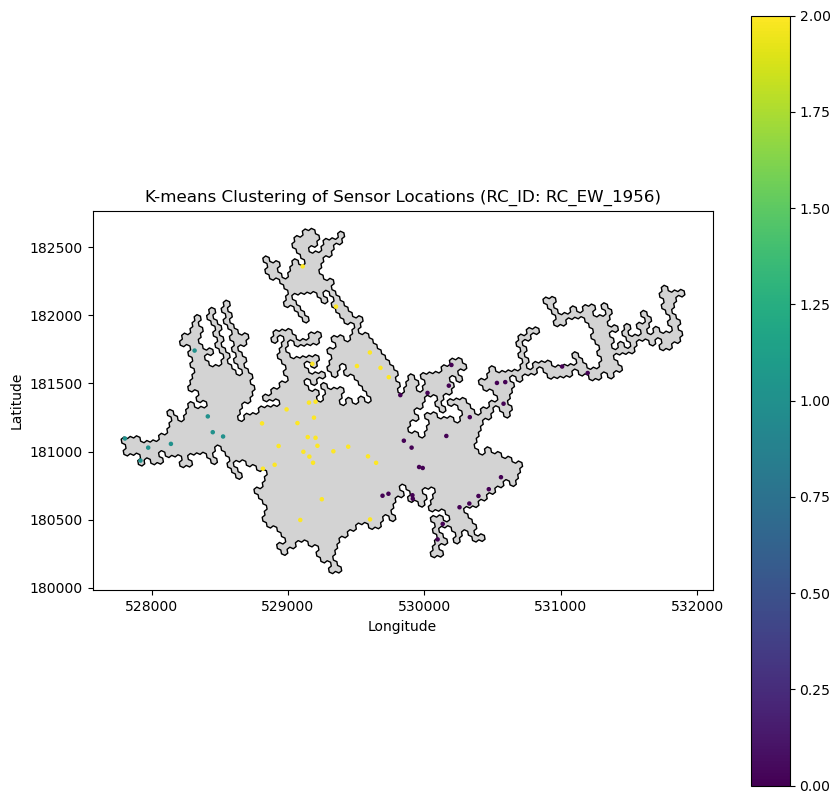

C:\Users\MJ\AppData\Local\Temp\ipykernel_18524\95577779.py:17: UserWarning: Geometry column does not contain geometry.
  gdf_sensors_highest_density['geometry'] = gdf_sensors_highest_density['geometry'].apply(lambda x: x.wkt)


In [36]:
conn = sqlite3.connect(sqlite_db_path)

sensor_coords_highest_density = np.array(list(gdf_sensors_highest_density.geometry.apply(lambda geom: (geom.x, geom.y))))
kmeans = KMeans(n_clusters=3, random_state=42).fit(sensor_coords_highest_density)
gdf_sensors_highest_density['cluster'] = kmeans.labels_

fig, ax = plt.subplots(figsize=(10, 10))
gdf_highest_density_area.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_sensors_highest_density.plot(ax=ax, column='cluster', cmap='viridis', legend=True, markersize=5)
ax.set_title(f'K-means Clustering of Sensor Locations (RC_ID: {highest_density_rc_id})')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

# Convert geometry to WKT format for saving to SQLite
gdf_sensors_highest_density['geometry'] = gdf_sensors_highest_density['geometry'].apply(lambda x: x.wkt)

# Save the clustered sensor data to SQLite
gdf_sensors_highest_density.to_sql('sensors_within_highest_density_area', conn, if_exists='replace', index=False)

conn.close()

## 5.0 | Initial Modelling

### 5.1 Only use footfall data for initial test

#### 5.1.1 Load Cleaned Footfall Data and Filter specific time

In [37]:
# Load cleaned footfall data which was filtered by study area and valid active time
df_footfall.head()

,location,device,footfall,hour,day_of_week,month,season
timestamp,,,,,,,
2018-01-01,800,750,3,0,0,1,1
2018-01-01,457,754,327,0,0,1,1
2018-01-01,99,764,4,0,0,1,1
2018-01-01,98,765,14,0,0,1,1
2018-01-01,84,768,23,0,0,1,1


In [38]:
# Connect to SQLite database
conn = sqlite3.connect(sqlite_db_path)

# Check if 'timestamp' is in columns or is already the index
if 'timestamp' in df_footfall.columns:
    # Set 'timestamp' as index if it's not already set
    df_footfall.set_index('timestamp', inplace=True)
elif df_footfall.index.name != 'timestamp':
    raise KeyError("The 'timestamp' column is missing, and it is not set as the index.")

# Ensure columns are consistent
df_footfall = df_footfall[['location', 'device', 'footfall']]

# Separate the 'timestamp' column into 'date' and 'time' columns
df_footfall['date'] = df_footfall.index.date
df_footfall['time'] = df_footfall.index.time

print("Footfall data with separated date and time:")
print(df_footfall.head())

Footfall data with separated date and time:
           location  device  footfall        date      time
timestamp                                                  
2018-01-01      800     750         3  2018-01-01  00:00:00
2018-01-01      457     754       327  2018-01-01  00:00:00
2018-01-01       99     764         4  2018-01-01  00:00:00
2018-01-01       98     765        14  2018-01-01  00:00:00
2018-01-01       84     768        23  2018-01-01  00:00:00


In [39]:
# Convert 'date' column to datetime type for easier manipulation
df_footfall['date'] = pd.to_datetime(df_footfall['date'])

# Add necessary columns for year, month, week, and weekday
df_footfall['year'] = df_footfall['date'].dt.year
df_footfall['month'] = df_footfall['date'].dt.month
df_footfall['week'] = df_footfall['date'].dt.isocalendar().week
df_footfall['weekday'] = df_footfall['date'].dt.weekday

# Filter data for October 2018
october_2018 = df_footfall[(df_footfall['year'] == 2018) & (df_footfall['month'] == 10)]

# Select the first week of October (Monday to Friday)
first_week_october = october_2018[october_2018['week'] == october_2018['week'].min()]
first_week_october = first_week_october[first_week_october['weekday'] < 5]

In [40]:
print(gdf_sensors_retail)

    location       lat      lon                   geometry  index_right  \
3         11  51.51684 -0.12749  POINT (-0.12749 51.51684)          210   
5         13  51.51738 -0.12013  POINT (-0.12013 51.51738)          210   
9          3  51.52128 -0.12370   POINT (-0.1237 51.52128)         4893   
18        38  51.37525 -0.10120   POINT (-0.1012 51.37525)          135   
23        57  51.51742 -0.11925  POINT (-0.11925 51.51742)          210   
..       ...       ...      ...                        ...          ...   
461      875  51.51670 -0.17253   POINT (-0.17253 51.5167)          963   
463      919  51.50466 -0.09000     POINT (-0.09 51.50466)          204   
469     1138  51.51586 -0.10817  POINT (-0.10817 51.51586)         2312   
471     1136  51.51915 -0.09018  POINT (-0.09018 51.51915)         2283   
474     1139  51.51586 -0.10817  POINT (-0.10817 51.51586)         2312   

          RC_ID                                            RC_Name  \
3    RC_EW_1956              

In [41]:
highest_density_rc_id = 'RC_EW_1956'

# Load sensor data with RC_ID information
sensor_data = pd.read_sql('SELECT * FROM filtered_footfall', conn)

# Load sensor location data
sensor_locations = pd.read_sql('SELECT * FROM ff_locations', conn)

# Filter sensors in the highest density area
sensor_locations_in_highest_density_area = sensor_locations[sensor_locations['location'] == highest_density_rc_id]

print("Sensor locations in highest density area:")

sensor_locations_in_highest_density_area = gdf_sensors_retail[gdf_sensors_retail['RC_ID'] == highest_density_rc_id]

print(sensor_locations_in_highest_density_area)

Sensor locations in highest density area:
    location        lat       lon                   geometry  index_right  \
3         11  51.516840 -0.127490  POINT (-0.12749 51.51684)          210   
5         13  51.517380 -0.120130  POINT (-0.12013 51.51738)          210   
23        57  51.517420 -0.119250  POINT (-0.11925 51.51742)          210   
34        98  51.513150 -0.137590  POINT (-0.13759 51.51315)          210   
37       103  51.511900 -0.128200    POINT (-0.1282 51.5119)          210   
..       ...        ...       ...                        ...          ...   
451      707  51.514070 -0.139440  POINT (-0.13944 51.51407)          210   
453      710  51.515990 -0.142420  POINT (-0.14242 51.51599)          210   
454      711  51.522679 -0.136925  POINT (-0.13692 51.52268)          210   
455      713  51.518570 -0.132390  POINT (-0.13239 51.51857)          210   
458      791  51.509960 -0.122390  POINT (-0.12239 51.50996)          210   

          RC_ID                  

In [42]:
# Get the list of locations in the highest density area
locations_in_highest_density_area = sensor_locations_in_highest_density_area['location'].unique()

print("Locations in the highest density area:")
print(locations_in_highest_density_area)

Locations in the highest density area:
['11' '13' '57' '98' '103' '121' '122' '123' '124' '125' '127' '130' '133'
 '134' '150' '111' '212' '217' '282' '300' '313' '319' '320' '430' '457'
 '495' '497' '534' '535' '545' '546' '583' '683' '743' '744' '778' '846'
 '851' '853' '854' '855' '873' '803' '804' '805' '806' '953' '955' '982'
 '983' '1037' '1101' '1102' '1123' '118' '119' '573' '574' '707' '710'
 '711' '713' '791']


In [43]:
# Define the RC_ID for the area with the highest sensor density
highest_density_rc_id = 'RC_EW_1956'

# Filter sensors located in the highest density area
sensor_locations_in_highest_density_area = gdf_sensors_retail[gdf_sensors_retail['RC_ID'] == highest_density_rc_id]

# Extract the unique locations in the highest density area
locations_in_highest_density_area = sensor_locations_in_highest_density_area['location'].unique()

print("Locations in the highest density area:")
print(locations_in_highest_density_area)

# Filter footfall data based on the identified locations
footfall_data_highest_density_area = df_footfall[df_footfall['location'].isin(locations_in_highest_density_area)]

# Display the filtered footfall data
print("Footfall data for devices in the highest density area:")
print(footfall_data_highest_density_area.head())

Locations in the highest density area:
['11' '13' '57' '98' '103' '121' '122' '123' '124' '125' '127' '130' '133'
 '134' '150' '111' '212' '217' '282' '300' '313' '319' '320' '430' '457'
 '495' '497' '534' '535' '545' '546' '583' '683' '743' '744' '778' '846'
 '851' '853' '854' '855' '873' '803' '804' '805' '806' '953' '955' '982'
 '983' '1037' '1101' '1102' '1123' '118' '119' '573' '574' '707' '710'
 '711' '713' '791']
Footfall data for devices in the highest density area:
           location  device  footfall       date      time  year  month  week  \
timestamp                                                                       
2018-01-01      457     754       327 2018-01-01  00:00:00  2018      1     1   
2018-01-01       98     765        14 2018-01-01  00:00:00  2018      1     1   
2018-01-01      806     770         3 2018-01-01  00:00:00  2018      1     1   
2018-01-01      535     772        44 2018-01-01  00:00:00  2018      1     1   
2018-01-01      125     796        

#### 5.1.2 Modelling only use footfall

In [44]:
from scipy.stats import normaltest
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [45]:
# XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.1,
    'seed': 42
}

# List to store MSE values for each device
mse_footfall_initial_values = []

# Iterate over each device in the filtered footfall data
for device in footfall_data_highest_density_area['device'].unique():
    # Filter the data for the current device
    device_data = footfall_data_highest_density_area[footfall_data_highest_density_area['device'] == device].copy()
    
    # Create lag features (from previous 1 to 24 hours)
    for lag in range(1, 25):
        device_data[f'lag_{lag}'] = device_data['footfall'].shift(lag)

    # Drop rows with missing values due to lagging
    device_data = device_data.dropna()

    # X_footfall_initial consists of lag features; y_footfall_initial is the current hour's footfall
    X_footfall_initial = device_data[[col for col in device_data.columns if col.startswith('lag_')]]
    y_footfall_initial = device_data['footfall']

    # Split the data into training and testing sets, keeping the time order intact
    X_footfall_initial_train, X_footfall_initial_test, y_footfall_initial_train, y_footfall_initial_test = train_test_split(
        X_footfall_initial, y_footfall_initial, test_size=0.2, random_state=42, shuffle=False
    )

    # Create DMatrix for XGBoost model
    dtrain_footfall_initial = xgb.DMatrix(X_footfall_initial_train, label=y_footfall_initial_train)
    dtest_footfall_initial = xgb.DMatrix(X_footfall_initial_test, label=y_footfall_initial_test)

    # Train the XGBoost model
    bst_footfall_initial = xgb.train(params, dtrain_footfall_initial, num_boost_round=100)

    # Make predictions using the trained model
    y_pred_footfall_initial = bst_footfall_initial.predict(dtest_footfall_initial)

    # Calculate MSE for the current device
    mse_footfall_initial = mean_squared_error(y_footfall_initial_test, y_pred_footfall_initial)
    mse_footfall_initial_values.append(mse_footfall_initial)

    # Print the MSE for the current device
    print(f'Device {device} - MSE: {mse_footfall_initial}')

# Calculate mean squared error for model evaluation
final_mse_footfall_initial = np.mean(mse_footfall_initial_values)
print(f'Mean Squared Error for initial test: {final_mse_footfall_initial}')

Device 754 - MSE: 1559.0888424446998
Device 765 - MSE: 265.39318899507276
Device 770 - MSE: 137.01514638724535
Device 772 - MSE: 536.6816086025743
Device 796 - MSE: 598.966695484937
Device 815 - MSE: 855.3904840225803
Device 877 - MSE: 1624.8167211352086
Device 887 - MSE: 447.0768769380506
Device 918 - MSE: 176.45621259760134
Device 963 - MSE: 81.02857476134972
Device 1018 - MSE: 857.1037926843902
Device 1028 - MSE: 118.0269485784315
Device 1033 - MSE: 189.87577311395808
Device 1068 - MSE: 648.3081745412362
Device 1109 - MSE: 299.7330404116908
Device 1122 - MSE: 3509.757653661387
Device 1129 - MSE: 908.516305673885
Device 1138 - MSE: 184.98507202524723
Device 1160 - MSE: 1030.4627048514055
Device 1176 - MSE: 353.25593205039587
Device 1193 - MSE: 1234.7644134255736
Device 1203 - MSE: 288.1108162298727
Device 1204 - MSE: 372.08465693433027
Device 1213 - MSE: 718.636658725059
Device 1245 - MSE: 1504.6064032154875
Device 1271 - MSE: 289.1439612523049
Device 1281 - MSE: 1085.1009887980656
D

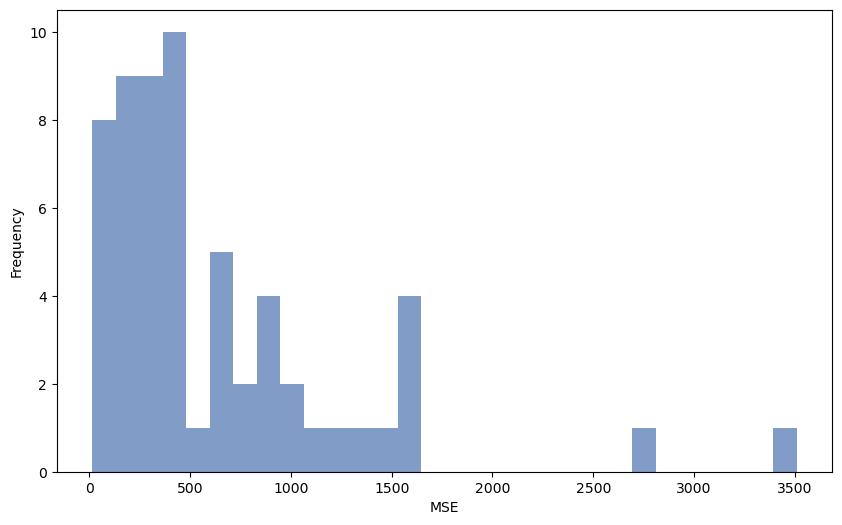

In [46]:
# Step 2: Plot the distribution of MSE values
plt.figure(figsize=(10, 6))
plt.hist(mse_footfall_initial_values, bins=30, alpha=0.7, color='#4C72B0')
plt.xlabel('MSE')
plt.ylabel('Frequency')

# Save the plot as an image file
plt.savefig('./figures/mse_distribution_X_footfall_initial.png', bbox_inches='tight')

# Show the plot
plt.show()

In [47]:
# Step 3: Test if the distribution of MSE is normal
stat, p_value = normaltest(mse_footfall_initial_values)
print(f'Normality test p-value: {p_value}')

# If the p-value is greater than 0.05, assume normal distribution
if p_value > 0.05:
    print('MSE distribution appears to be normal.')
    
    # Calculate the average MSE if distribution is normal
    average_mse_footfall_initial = np.mean(mse_footfall_initial_values)
    print(f'Average MSE: {average_mse_footfall_initial}')
else:
    print('MSE distribution does not appear to be normal.')

Normality test p-value: 7.910116735874324e-11
MSE distribution does not appear to be normal.


In [48]:
# Apply log transformation
log_mse_footfall_initial_values = np.log(mse_footfall_initial_values)

# Re-test for normality after log transformation
stat, p_value = normaltest(log_mse_footfall_initial_values)
print(f'Normality test on log-transformed MSE p-value: {p_value}')

# If the distribution is normal, calculate the mean of the log-transformed MSE
if p_value > 0.05:
    print('Log-transformed MSE distribution appears to be normal.')
    mean_log_mse_footfall_initial = np.mean(log_mse_footfall_initial_values)
    print(f'Mean of log-transformed MSE: {mean_log_mse_footfall_initial}')
else:
    print('Log-transformed MSE distribution does not appear to be normal.')

Normality test on log-transformed MSE p-value: 0.12119810243912531
Log-transformed MSE distribution appears to be normal.
Mean of log-transformed MSE: 5.996475289578535


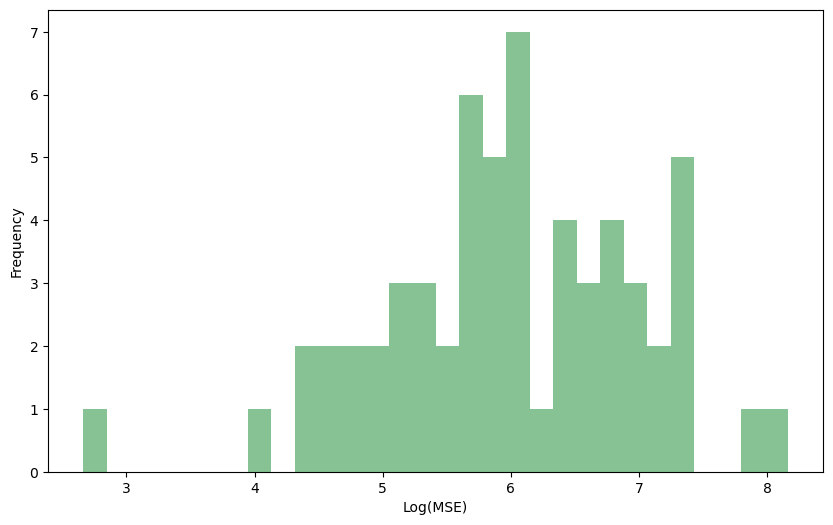

In [49]:
# Plot the log-transformed MSE distribution
plt.figure(figsize=(10, 6))
plt.hist(log_mse_footfall_initial_values, bins=30, alpha=0.7, color='#55A868')
plt.xlabel('Log(MSE)')
plt.ylabel('Frequency')

# Save the plot as an image file
plt.savefig('./figures/log_mse_distribution_X_footfall_initial.png', bbox_inches='tight')

# Show the plot
plt.show()

In [50]:
# Calculate the average MSE and mean of log-transformed MSE
average_mse_footfall_initial = np.mean(mse_footfall_initial_values)
mean_log_mse_footfall_initial = np.mean(log_mse_footfall_initial_values)

# Print the results
print(f'Average MSE: {average_mse_footfall_initial}')
print(f'Mean of log-transformed MSE: {mean_log_mse_footfall_initial}')

Average MSE: 630.5964143467471
Mean of log-transformed MSE: 5.996475289578535


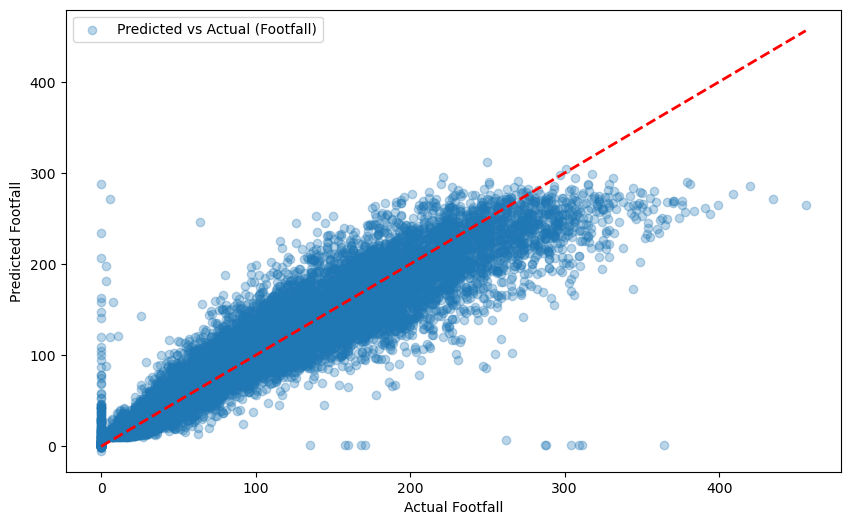

In [51]:
# Find the device with the MSE closest to the average MSE
closest_device_index = np.argmin([abs(mse - average_mse_footfall_initial) for mse in mse_footfall_initial_values])
closest_device = footfall_data_highest_density_area['device'].unique()[closest_device_index]

# Use the data from this closest device for visualization
device_data_footfall_initial = footfall_data_highest_density_area[footfall_data_highest_density_area['device'] == closest_device].copy()

# Create lag features (from previous 1 to 24 hours)
for lag in range(1, 25):
    device_data_footfall_initial[f'lag_{lag}'] = device_data_footfall_initial['footfall'].shift(lag)

# Drop rows with missing values due to lagging
device_data_footfall_initial = device_data_footfall_initial.dropna()

# X_footfall_initial includes lag features; y_footfall_initial is the current hour's footfall
X_footfall_initial = device_data_footfall_initial[[col for col in device_data_footfall_initial.columns if col.startswith('lag_')]]
y_footfall_initial = device_data_footfall_initial['footfall']

# Split the data into training and testing sets, keeping the time order intact
X_footfall_initial_train, X_footfall_initial_test, y_footfall_initial_train, y_footfall_initial_test = train_test_split(
    X_footfall_initial, y_footfall_initial, test_size=0.2, random_state=42, shuffle=False
)

# Create DMatrix for XGBoost model
dtrain_footfall_initial = xgb.DMatrix(X_footfall_initial_train, label=y_footfall_initial_train)
dtest_footfall_initial = xgb.DMatrix(X_footfall_initial_test, label=y_footfall_initial_test)

# Train the XGBoost model
bst_footfall_initial = xgb.train(params, dtrain_footfall_initial, num_boost_round=100)

# Make predictions using the trained model
y_pred_footfall_initial = bst_footfall_initial.predict(dtest_footfall_initial)

# Visualize the actual vs predicted footfall for the representative device
plt.figure(figsize=(10, 6))
plt.scatter(y_footfall_initial_test, y_pred_footfall_initial, alpha=0.3, label='Predicted vs Actual (Footfall)')
plt.plot([y_footfall_initial_test.min(), y_footfall_initial_test.max()], 
         [y_footfall_initial_test.min(), y_footfall_initial_test.max()], 'r--', lw=2)
plt.xlabel('Actual Footfall')
plt.ylabel('Predicted Footfall')
plt.legend()

# Save the plot as an image file
plt.savefig(f'./figures/actual_vs_predicted_footfall_initialtest_device_{closest_device}.png', bbox_inches='tight')

# Show the plot
plt.show()

### 5.2 Add Weather Data

#### 5.2.1  Load and Clean Weather Data 

In [52]:
pip install meteostat

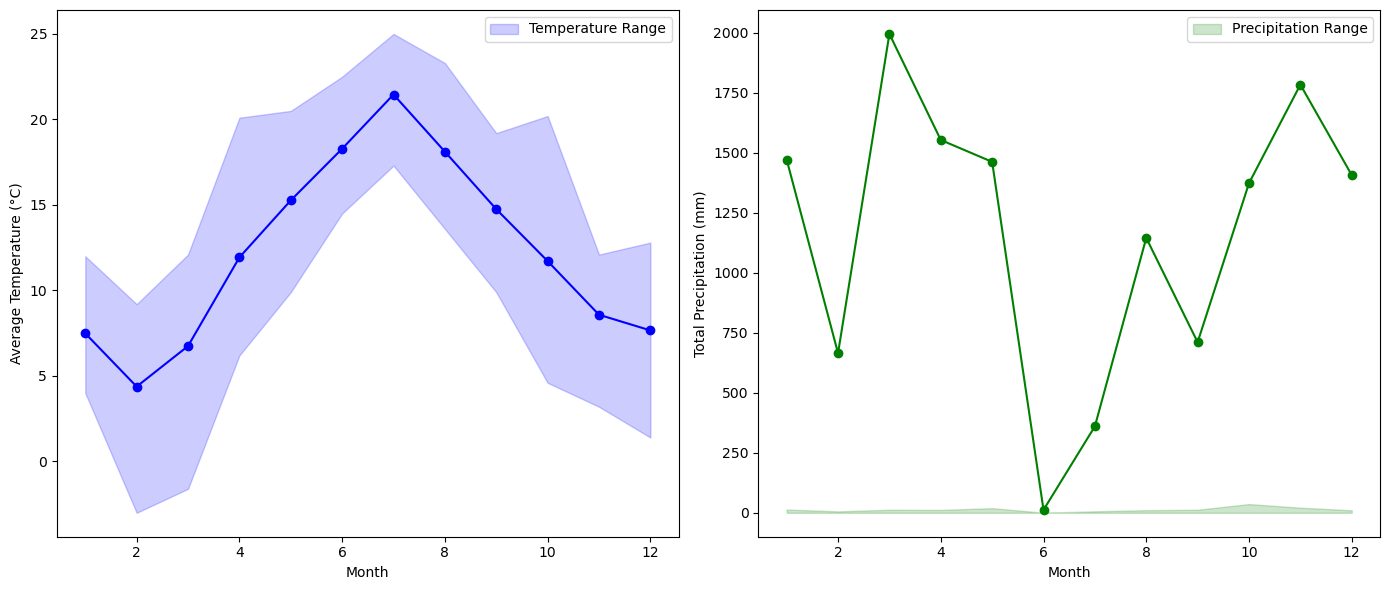

Monthly Weather Data with Temperature and Precipitation Ranges:
    year month       tavg          prcp      
                     mean range     sum range
0   2018     1   7.490323   8.0  1471.2  13.7
1   2018     2   4.378571  12.2   664.8   5.8
2   2018     3   6.748387  13.7  1994.4  12.7
3   2018     4  11.933333  13.9  1552.8  11.9
4   2018     5  15.267742  10.6  1461.6  19.3
5   2018     6  18.286667   8.0    12.0   0.5
6   2018     7  21.458065   7.7   360.0   6.1
7   2018     8  18.116129   9.7  1144.8  10.9
8   2018     9  14.753333   9.3   710.4  12.7
9   2018    10  11.716129  15.6  1372.8  36.3
10  2018    11   8.580000   8.9  1783.2  21.3
11  2018    12   7.664355  11.4  1406.4  10.4


In [54]:
from meteostat import Point, Daily
from datetime import datetime
import matplotlib.pyplot as plt
import os

# Define location for weather data (London)
location = Point(51.5074, -0.1278)

# Define the date range for the weather data (matching footfall data)
start = datetime(2018, 1, 1)
end = datetime(2018, 12, 31)

# Fetch daily weather data (temperature and precipitation) for the selected dates
weather_data = Daily(location, start, end)
weather_data = weather_data.fetch()

# Keep only average temperature ('tavg') and precipitation ('prcp') columns
weather_data = weather_data[['tavg', 'prcp']]

# Resample the daily data to hourly data using forward fill to fill missing hours
weather_data_hourly = weather_data.resample('H').ffill()

# Ensure the DataFrame's structure is consistent by resetting the index
weather_data_hourly = weather_data_hourly.reset_index()
weather_data_hourly.columns = ['timestamp', 'tavg', 'prcp']

# Separate the 'timestamp' column into 'date' and 'time' columns for easier merging
weather_data_hourly['timestamp'] = pd.to_datetime(weather_data_hourly['timestamp'])
weather_data_hourly['date'] = weather_data_hourly['timestamp'].dt.date
weather_data_hourly['time'] = weather_data_hourly['timestamp'].dt.time

# Extract month and year for aggregation
weather_data_hourly['year'] = weather_data_hourly['timestamp'].dt.year
weather_data_hourly['month'] = weather_data_hourly['timestamp'].dt.month

# Aggregate the data by month to calculate average temperature and total precipitation
monthly_weather = weather_data_hourly.groupby(['year', 'month']).agg({
    'tavg': ['mean', 'min', 'max'],  # Average, Min, Max temperature
    'prcp': ['sum', 'min', 'max']    # Total precipitation, Min, Max precipitation
}).reset_index()

# Calculate the range for temperature and precipitation
monthly_weather[('tavg', 'range')] = monthly_weather[('tavg', 'max')] - monthly_weather[('tavg', 'min')]
monthly_weather[('prcp', 'range')] = monthly_weather[('prcp', 'max')] - monthly_weather[('prcp', 'min')]

# Plotting the monthly average temperature and total precipitation
plt.figure(figsize=(14, 6))

# Plot average temperature
plt.subplot(1, 2, 1)
plt.plot(monthly_weather['month'], monthly_weather[('tavg', 'mean')], marker='o', color='b')
plt.fill_between(monthly_weather['month'], monthly_weather[('tavg', 'min')], monthly_weather[('tavg', 'max')],
                 color='blue', alpha=0.2, label='Temperature Range')
plt.xlabel('Month')
plt.ylabel('Average Temperature (°C)')
plt.legend()

# Plot total precipitation
plt.subplot(1, 2, 2)
plt.plot(monthly_weather['month'], monthly_weather[('prcp', 'sum')], marker='o', color='g')
plt.fill_between(monthly_weather['month'], monthly_weather[('prcp', 'min')], monthly_weather[('prcp', 'max')],
                 color='green', alpha=0.2, label='Precipitation Range')
plt.xlabel('Month')
plt.ylabel('Total Precipitation (mm)')
plt.legend()

plt.tight_layout()

# Save the plot as an image file without titles
output_dir = './figures' 
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'monthly_weather_temperature_precipitation.png'), bbox_inches='tight')

# Show the plot
plt.show()

# Display the monthly weather data with range
print("Monthly Weather Data with Temperature and Precipitation Ranges:")
print(monthly_weather[[('year', ''), ('month', ''), ('tavg', 'mean'), ('tavg', 'range'), ('prcp', 'sum'), ('prcp', 'range')]])

In [55]:
# Splitting the timestamp into separate date and time columns for easier merging with weather data.
footfall_data_highest_density_area['date'] = footfall_data_highest_density_area.index.date
footfall_data_highest_density_area['time'] = footfall_data_highest_density_area.index.time

# Merging the footfall data with weather data (temperature and precipitation) based on the date and time.
merged_data_with_weather = pd.merge(
    footfall_data_highest_density_area, 
    weather_data_hourly[['date', 'time', 'tavg', 'prcp']], 
    how='inner', 
    on=['date', 'time']
)

print("Merged footfall data with weather data:")
print(merged_data_with_weather.head())

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Merged footfall data with weather data:
  location  device  footfall        date      time  year  month  week  \
0      457     754       327  2018-01-01  00:00:00  2018      1     1   
1       98     765        14  2018-01-01  00:00:00  2018      1     1   
2      806     770         3  2018-01-01  00:00:00  2018      1     1   
3      535     772        44  2018-01-01  00:00:00  2018      1     1   
4      125     796        29  2018-01-01  00:00:00  2018      1     1   

   weekday  tavg  prcp  
0        0   7.8   5.1  
1        0   7.8   5.1  
2        0   7.8   5.1  
3        0   7.8   5.1  
4        0   7.8   5.1  


#### 5.2.2 Add Temperature Data and Modelling

In [56]:
# List to store MSE values for each device
mse_temp_initial_values = []

# Iterate over each device in the merged footfall data
for device in merged_data_with_weather['device'].unique():
    # Filter the data for the current device
    device_data_temp_initial = merged_data_with_weather[merged_data_with_weather['device'] == device].copy()
    
    # Create lag features (from previous 1 to 24 hours) including only temperature data
    for lag in range(1, 25):
        device_data_temp_initial[f'lag_{lag}'] = device_data_temp_initial['footfall'].shift(lag)
        device_data_temp_initial[f'tavg_lag_{lag}'] = device_data_temp_initial['tavg'].shift(lag)

    # Drop rows with missing values due to lagging
    device_data_temp_initial = device_data_temp_initial.dropna()

    # X_temp_initial includes lag features and temperature data; y_temp_initial is the current hour's footfall
    X_temp_initial = device_data_temp_initial[[col for col in device_data_temp_initial.columns if col.startswith('lag_')] + ['tavg']]
    y_temp_initial = device_data_temp_initial['footfall']

    # Split the data into training and testing sets, keeping the time order intact
    X_temp_initial_train, X_temp_initial_test, y_temp_initial_train, y_temp_initial_test = train_test_split(
        X_temp_initial, y_temp_initial, test_size=0.2, random_state=42, shuffle=False
    )

    # Create DMatrix for XGBoost model
    dtrain_temp_initial = xgb.DMatrix(X_temp_initial_train, label=y_temp_initial_train)
    dtest_temp_initial = xgb.DMatrix(X_temp_initial_test, label=y_temp_initial_test)

    # Train the XGBoost model
    bst_temp_initial = xgb.train(params, dtrain_temp_initial, num_boost_round=100)

    # Make predictions using the trained model
    y_pred_temp_initial = bst_temp_initial.predict(dtest_temp_initial)

    # Calculate MSE for the current device
    mse_temp_initial = mean_squared_error(y_temp_initial_test, y_pred_temp_initial)
    mse_temp_initial_values.append(mse_temp_initial)

    # Print the MSE for the current device
    print(f'Device {device} - MSE: {mse_temp_initial}')

Device 754 - MSE: 2981.9672019217937
Device 765 - MSE: 376.6287593360155
Device 770 - MSE: 222.68348858336944
Device 772 - MSE: 723.7104274161511
Device 796 - MSE: 992.6841615889738
Device 815 - MSE: 1250.67061443111
Device 877 - MSE: 2563.1608780127567
Device 887 - MSE: 650.7771781511077
Device 918 - MSE: 243.56351686102636
Device 963 - MSE: 633.0081490345175
Device 1018 - MSE: 1309.216588689766
Device 1028 - MSE: 139.5126030429348
Device 1033 - MSE: 266.25200539692435
Device 1068 - MSE: 1462.277631027576
Device 1109 - MSE: 587.9310679628469
Device 1122 - MSE: 6892.106357552183
Device 1129 - MSE: 2386.33865406874
Device 1138 - MSE: 259.0699815016319
Device 1160 - MSE: 2028.1236735248003
Device 1176 - MSE: 684.1712625364341
Device 1193 - MSE: 2424.639041570779
Device 1203 - MSE: 375.6178791441877
Device 1204 - MSE: 669.85162429291
Device 1213 - MSE: 1888.4129906779451
Device 1245 - MSE: 2988.414854400561
Device 1271 - MSE: 398.15698498377174
Device 1281 - MSE: 2139.0612332520095
Device

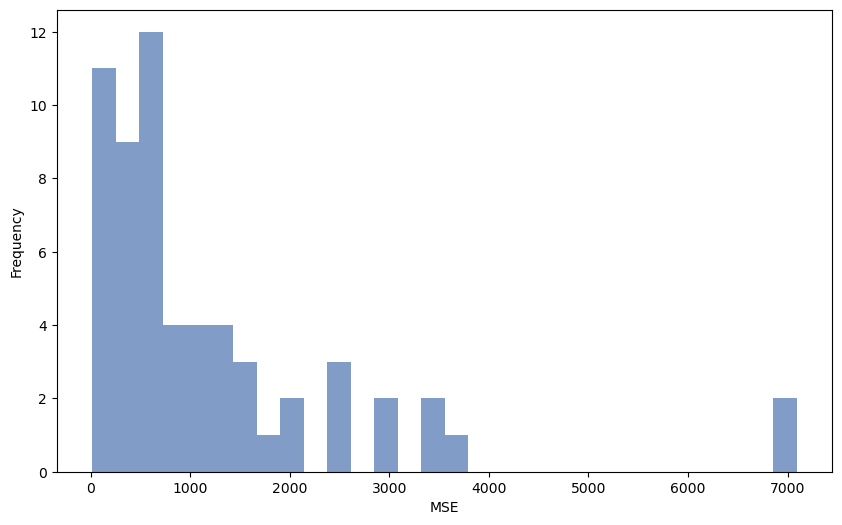

In [57]:
# Step 2: Plot the distribution of MSE values
plt.figure(figsize=(10, 6))
plt.hist(mse_temp_initial_values, bins=30, alpha=0.7, color='#4C72B0')
plt.xlabel('MSE')
plt.ylabel('Frequency')

# Save the plot as an image file
plt.savefig('./figures/mse_distribution_X_temp_initial.png', bbox_inches='tight')

# Show the plot
plt.show()

In [58]:
# Step 3: Test if the distribution of MSE is normal
stat, p_value = normaltest(mse_temp_initial_values)
print(f'Normality test p-value: {p_value}')

# If the p-value is greater than 0.05, assume normal distribution
if p_value > 0.05:
    print('MSE distribution appears to be normal.')
    
    # Calculate the average MSE if distribution is normal
    average_mse_temp_initial = np.mean(mse_temp_initial_values)
    print(f'Average MSE: {average_mse_temp_initial}')
else:
    print('MSE distribution does not appear to be normal.')

Normality test p-value: 2.2516159488444186e-11
MSE distribution does not appear to be normal.


In [59]:
# Apply log transformation
log_mse_temp_initial_values = np.log(mse_temp_initial_values)

# Re-test for normality after log transformation
stat, p_value = normaltest(log_mse_temp_initial_values)
print(f'Normality test on log-transformed MSE p-value: {p_value}')

# If the distribution is normal, calculate the mean of the log-transformed MSE
if p_value > 0.05:
    print('Log-transformed MSE distribution appears to be normal.')
    mean_log_mse_temp_initial = np.mean(log_mse_temp_initial_values)
    print(f'Mean of log-transformed MSE: {mean_log_mse_temp_initial}')
else:
    print('Log-transformed MSE distribution does not appear to be normal.')

Normality test on log-transformed MSE p-value: 0.09621546914066828
Log-transformed MSE distribution appears to be normal.
Mean of log-transformed MSE: 6.561838236595737


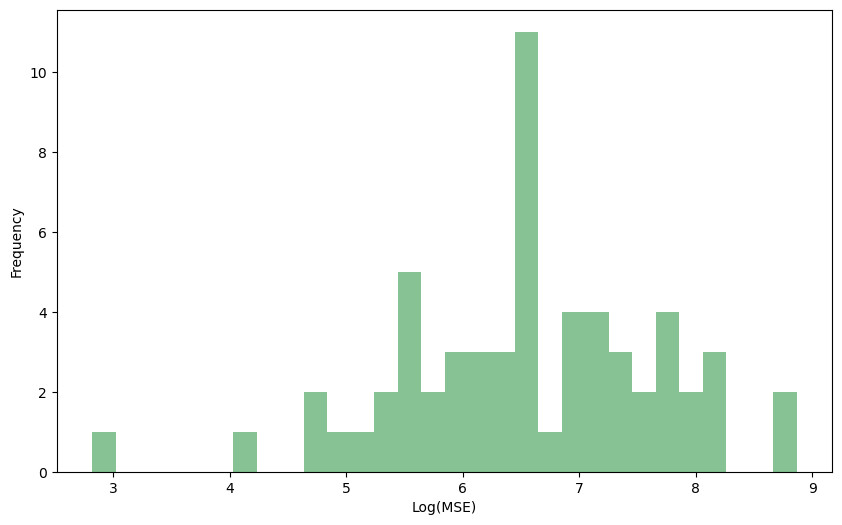

In [60]:
# Plot the log-transformed MSE distribution
plt.figure(figsize=(10, 6))
plt.hist(log_mse_temp_initial_values, bins=30, alpha=0.7, color='#55A868')
plt.xlabel('Log(MSE)')
plt.ylabel('Frequency')

# Save the plot as an image file
plt.savefig('./figures/log_mse_distribution_X_temp_initial.png', bbox_inches='tight')

# Show the plot
plt.show()

In [61]:
# Calculate the average MSE and mean of log-transformed MSE
average_mse_temp_initial = np.mean(mse_temp_initial_values)
mean_log_mse_temp_initial = np.mean(log_mse_temp_initial_values)

# Print the results
print(f'Average MSE: {average_mse_temp_initial}')
print(f'Mean of log-transformed MSE: {mean_log_mse_temp_initial}')

Average MSE: 1229.4395595825156
Mean of log-transformed MSE: 6.561838236595737


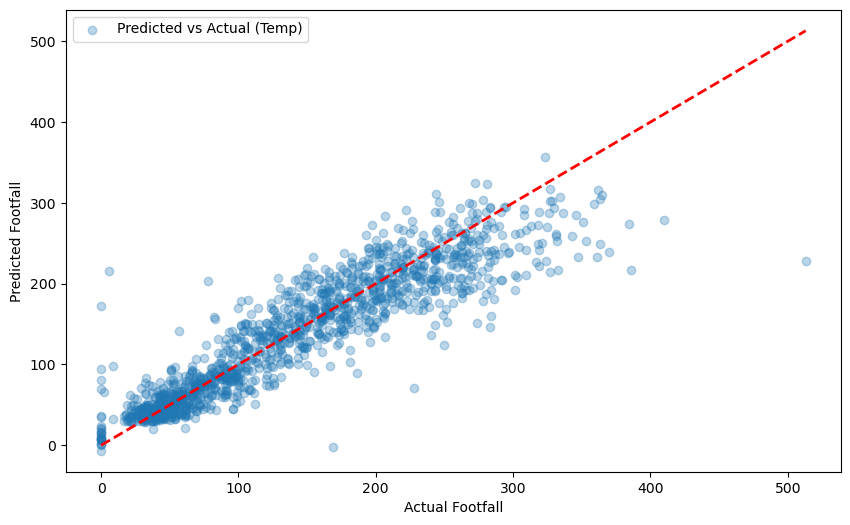

In [62]:
# Find the device with the MSE closest to the average MSE
closest_device_index = np.argmin([abs(mse - average_mse_temp_initial) for mse in mse_temp_initial_values])
closest_device = merged_data_with_weather['device'].unique()[closest_device_index]

# Use the data from this closest device for visualization
device_data_temp_initial = merged_data_with_weather[merged_data_with_weather['device'] == closest_device].copy()

# Create lag features (from previous 1 to 24 hours) including only temperature data
for lag in range(1, 25):
    device_data_temp_initial[f'lag_{lag}'] = device_data_temp_initial['footfall'].shift(lag)
    device_data_temp_initial[f'tavg_lag_{lag}'] = device_data_temp_initial['tavg'].shift(lag)

# Drop rows with missing values due to lagging
device_data_temp_initial = device_data_temp_initial.dropna()

# X_temp_initial includes lag features and temperature data; y_temp_initial is the current hour's footfall
X_temp_initial = device_data_temp_initial[[col for col in device_data_temp_initial.columns if col.startswith('lag_')] + ['tavg']]
y_temp_initial = device_data_temp_initial['footfall']

# Split the data into training and testing sets, keeping the time order intact
X_temp_initial_train, X_temp_initial_test, y_temp_initial_train, y_temp_initial_test = train_test_split(
    X_temp_initial, y_temp_initial, test_size=0.2, random_state=42, shuffle=False
)

# Create DMatrix for XGBoost model
dtrain_temp_initial = xgb.DMatrix(X_temp_initial_train, label=y_temp_initial_train)
dtest_temp_initial = xgb.DMatrix(X_temp_initial_test, label=y_temp_initial_test)

# Train the XGBoost model
bst_temp_initial = xgb.train(params, dtrain_temp_initial, num_boost_round=100)

# Make predictions using the trained model
y_pred_temp_initial = bst_temp_initial.predict(dtest_temp_initial)

# Visualize the actual vs predicted footfall for the representative device
plt.figure(figsize=(10, 6))
plt.scatter(y_temp_initial_test, y_pred_temp_initial, alpha=0.3, label='Predicted vs Actual (Temp)')
plt.plot([y_temp_initial_test.min(), y_temp_initial_test.max()], 
         [y_temp_initial_test.min(), y_temp_initial_test.max()], 'r--', lw=2)
plt.xlabel('Actual Footfall')
plt.ylabel('Predicted Footfall')
plt.legend()

# Save the plot as an image file
plt.savefig(f'./figures/actual_vs_predicted_footfall_temp_initialtest_device_{closest_device}.png', bbox_inches='tight')

# Show the plot
plt.show()

# Close the database connection
conn.close()

#### 5.2.3 Add Precipitation Data and Modelling

In [63]:
# List to store MSE values for each device
mse_temp_prcp_initial_values = []

# Iterate over each device in the merged footfall data
for device in merged_data_with_weather['device'].unique():
    # Filter the data for the current device
    device_data_temp_prcp_initial = merged_data_with_weather[merged_data_with_weather['device'] == device].copy()
    
    # Create lag features (from previous 1 to 24 hours) including temperature and precipitation data
    for lag in range(1, 25):
        device_data_temp_prcp_initial[f'lag_{lag}'] = device_data_temp_prcp_initial['footfall'].shift(lag)
        device_data_temp_prcp_initial[f'tavg_lag_{lag}'] = device_data_temp_prcp_initial['tavg'].shift(lag)
        device_data_temp_prcp_initial[f'prcp_lag_{lag}'] = device_data_temp_prcp_initial['prcp'].shift(lag)

    # Drop rows with missing values due to lagging
    device_data_temp_prcp_initial = device_data_temp_prcp_initial.dropna()

    # X_temp_prcp_initial includes lag features, temperature, and precipitation data; y_temp_prcp_initial is the current hour's footfall
    X_temp_prcp_initial = device_data_temp_prcp_initial[[col for col in device_data_temp_prcp_initial.columns if col.startswith('lag_')] + ['tavg', 'prcp']]
    y_temp_prcp_initial = device_data_temp_prcp_initial['footfall']

    # Split the data into training and testing sets, keeping the time order intact
    X_temp_prcp_initial_train, X_temp_prcp_initial_test, y_temp_prcp_initial_train, y_temp_prcp_initial_test = train_test_split(
        X_temp_prcp_initial, y_temp_prcp_initial, test_size=0.2, random_state=42, shuffle=False
    )

    # Create DMatrix for XGBoost model
    dtrain_temp_prcp_initial = xgb.DMatrix(X_temp_prcp_initial_train, label=y_temp_prcp_initial_train)
    dtest_temp_prcp_initial = xgb.DMatrix(X_temp_prcp_initial_test, label=y_temp_prcp_initial_test)

    # Train the XGBoost model
    bst_temp_prcp_initial = xgb.train(params, dtrain_temp_prcp_initial, num_boost_round=100)

    # Make predictions using the trained model
    y_pred_temp_prcp_initial = bst_temp_prcp_initial.predict(dtest_temp_prcp_initial)

    # Calculate MSE for the current device
    mse_temp_prcp_initial = mean_squared_error(y_temp_prcp_initial_test, y_pred_temp_prcp_initial)
    mse_temp_prcp_initial_values.append(mse_temp_prcp_initial)

    # Print the MSE for the current device
    print(f'Device {device} - MSE: {mse_temp_prcp_initial}')

Device 754 - MSE: 3000.7507467918886
Device 765 - MSE: 395.6534148333239
Device 770 - MSE: 223.06949573109273
Device 772 - MSE: 713.669423887579
Device 796 - MSE: 993.2906123776548
Device 815 - MSE: 1226.8604813324832
Device 877 - MSE: 2597.9215791356196
Device 887 - MSE: 653.9284645434936
Device 918 - MSE: 249.71403730464897
Device 963 - MSE: 607.9601510975388
Device 1018 - MSE: 1340.9309117530952
Device 1028 - MSE: 142.58260077374013
Device 1033 - MSE: 275.2723864052266
Device 1068 - MSE: 1457.499208160473
Device 1109 - MSE: 577.4081281330583
Device 1122 - MSE: 6510.117338110274
Device 1129 - MSE: 2328.883779426608
Device 1138 - MSE: 259.52817545783427
Device 1160 - MSE: 2075.612734647206
Device 1176 - MSE: 682.3203762958412
Device 1193 - MSE: 2360.724042321543
Device 1203 - MSE: 364.2642381407586
Device 1204 - MSE: 662.4145346604723
Device 1213 - MSE: 1984.4583274137606
Device 1245 - MSE: 2977.933324988081
Device 1271 - MSE: 405.82055524335436
Device 1281 - MSE: 2079.465442398956
De

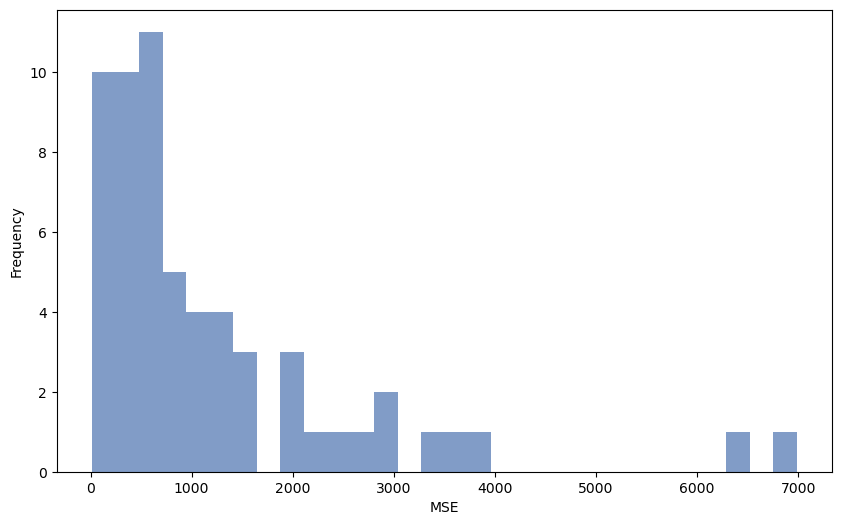

In [64]:
# Step 2: Plot the distribution of MSE values (Temperature + Precipitation)
plt.figure(figsize=(10, 6))
plt.hist(mse_temp_prcp_initial_values, bins=30, alpha=0.7, color='#4C72B0')
plt.xlabel('MSE')
plt.ylabel('Frequency')

# Save the plot as an image file
plt.savefig('./figures/mse_distribution_X_temp_prcp_initial.png', bbox_inches='tight')

# Show the plot
plt.show()

In [65]:
# Step 3: Test if the distribution of MSE is normal
stat, p_value = normaltest(mse_temp_prcp_initial_values)
print(f'Normality test p-value: {p_value}')

# If the p-value is greater than 0.05, assume normal distribution
if p_value > 0.05:
    print('MSE distribution appears to be normal.')
    
    # Calculate the average MSE if distribution is normal
    average_mse_temp_prcp_initial = np.mean(mse_temp_prcp_initial_values)
    print(f'Average MSE: {average_mse_temp_prcp_initial}')
else:
    print('MSE distribution does not appear to be normal.')

Normality test p-value: 6.821935498038017e-11
MSE distribution does not appear to be normal.


Normality test on log-transformed MSE p-value: 0.09361047316126384
Log-transformed MSE distribution appears to be normal.
Mean of log-transformed MSE: 6.558382931336026


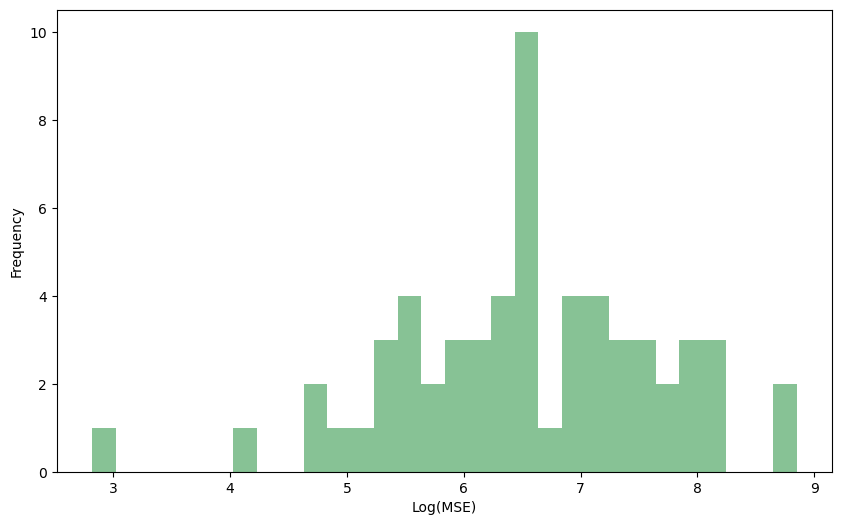

In [66]:
# Apply log transformation
log_mse_temp_prcp_initial_values = np.log(mse_temp_prcp_initial_values)

# Re-test for normality after log transformation
stat, p_value = normaltest(log_mse_temp_prcp_initial_values)
print(f'Normality test on log-transformed MSE p-value: {p_value}')

# If the distribution is normal, calculate the mean of the log-transformed MSE
if p_value > 0.05:
    print('Log-transformed MSE distribution appears to be normal.')
    mean_log_mse_temp_prcp_initial = np.mean(log_mse_temp_prcp_initial_values)
    print(f'Mean of log-transformed MSE: {mean_log_mse_temp_prcp_initial}')
else:
    print('Log-transformed MSE distribution does not appear to be normal.')

# Plot the log-transformed MSE distribution (Temperature + Precipitation)
plt.figure(figsize=(10, 6))
plt.hist(log_mse_temp_prcp_initial_values, bins=30, alpha=0.7, color='#55A868')
plt.xlabel('Log(MSE)')
plt.ylabel('Frequency')

# Save the plot as an image file
plt.savefig('./figures/log_mse_distribution_X_temp_prcp_initial.png', bbox_inches='tight')

# Show the plot
plt.show()

In [67]:
# Calculate the average MSE and mean of log-transformed MSE
average_mse_temp_prcp_initial = np.mean(mse_temp_prcp_initial_values)
mean_log_mse_temp_prcp_initial = np.mean(log_mse_temp_prcp_initial_values)

# Print the results
print(f'Average MSE: {average_mse_temp_prcp_initial}')
print(f'Mean of log-transformed MSE: {mean_log_mse_temp_prcp_initial}')

Average MSE: 1220.2351856986272
Mean of log-transformed MSE: 6.558382931336026


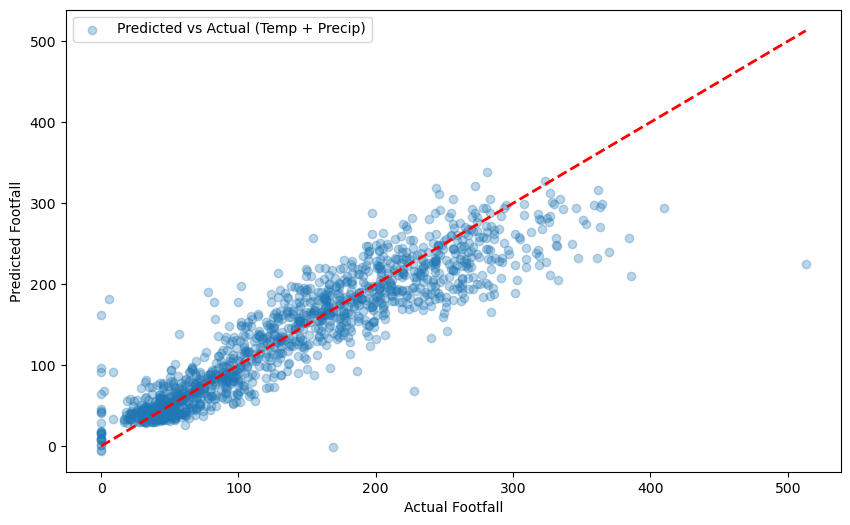

In [68]:
# Find the device with the MSE closest to the average MSE
closest_device_index = np.argmin([abs(mse - average_mse_temp_prcp_initial) for mse in mse_temp_prcp_initial_values])
closest_device = merged_data_with_weather['device'].unique()[closest_device_index]

# Use the data from this closest device for visualization
device_data_temp_prcp_initial = merged_data_with_weather[merged_data_with_weather['device'] == closest_device].copy()

# Create lag features (from previous 1 to 24 hours) including temperature and precipitation data
for lag in range(1, 25):
    device_data_temp_prcp_initial[f'lag_{lag}'] = device_data_temp_prcp_initial['footfall'].shift(lag)
    device_data_temp_prcp_initial[f'tavg_lag_{lag}'] = device_data_temp_prcp_initial['tavg'].shift(lag)
    device_data_temp_prcp_initial[f'prcp_lag_{lag}'] = device_data_temp_prcp_initial['prcp'].shift(lag)

# Drop rows with missing values due to lagging
device_data_temp_prcp_initial = device_data_temp_prcp_initial.dropna()

# X_temp_prcp_initial includes lag features, temperature, and precipitation data; y_temp_prcp_initial is the current hour's footfall
X_temp_prcp_initial = device_data_temp_prcp_initial[[col for col in device_data_temp_prcp_initial.columns if col.startswith('lag_')] + ['tavg', 'prcp']]
y_temp_prcp_initial = device_data_temp_prcp_initial['footfall']

# Split the data into training and testing sets, keeping the time order intact
X_temp_prcp_initial_train, X_temp_prcp_initial_test, y_temp_prcp_initial_train, y_temp_prcp_initial_test = train_test_split(
    X_temp_prcp_initial, y_temp_prcp_initial, test_size=0.2, random_state=42, shuffle=False
)

# Create DMatrix for XGBoost model
dtrain_temp_prcp_initial = xgb.DMatrix(X_temp_prcp_initial_train, label=y_temp_prcp_initial_train)
dtest_temp_prcp_initial = xgb.DMatrix(X_temp_prcp_initial_test, label=y_temp_prcp_initial_test)

# Train the XGBoost model
bst_temp_prcp_initial = xgb.train(params, dtrain_temp_prcp_initial, num_boost_round=100)

# Make predictions using the trained model
y_pred_temp_prcp_initial = bst_temp_prcp_initial.predict(dtest_temp_prcp_initial)

# Visualize the actual vs predicted footfall for the representative device
plt.figure(figsize=(10, 6))
plt.scatter(y_temp_prcp_initial_test, y_pred_temp_prcp_initial, alpha=0.3, label='Predicted vs Actual (Temp + Precip)')
plt.plot([y_temp_prcp_initial_test.min(), y_temp_prcp_initial_test.max()], 
         [y_temp_prcp_initial_test.min(), y_temp_prcp_initial_test.max()], 'r--', lw=2)
plt.xlabel('Actual Footfall')
plt.ylabel('Predicted Footfall')
plt.legend()

# Save the plot as an image file
plt.savefig(f'./figures/actual_vs_predicted_footfall_temp_prcp_initialtest_device_{closest_device}.png', bbox_inches='tight')

# Show the plot
plt.show()

## 6.0 | Further Modelling

### 6.1 Select one specific study-case station and its devices

In [69]:
# Load London stations data
london_stations = pd.read_csv('rawdata/London_stations.csv')
london_stations = london_stations[['Station', 'Latitude', 'Longitude']]

print("London stations data:")
print(london_stations.head())

London stations data:
           Station   Latitude  Longitude
0       Abbey Road  51.531952   0.003723
1       Abbey Wood  51.490784   0.120272
2    Acton Central  51.508757  -0.263430
3  Acton Main Line  51.516886  -0.267690
4       Acton Town  51.503071  -0.280303


In [70]:
print(sensor_locations_in_highest_density_area)

    location        lat       lon                   geometry  index_right  \
3         11  51.516840 -0.127490  POINT (-0.12749 51.51684)          210   
5         13  51.517380 -0.120130  POINT (-0.12013 51.51738)          210   
23        57  51.517420 -0.119250  POINT (-0.11925 51.51742)          210   
34        98  51.513150 -0.137590  POINT (-0.13759 51.51315)          210   
37       103  51.511900 -0.128200    POINT (-0.1282 51.5119)          210   
..       ...        ...       ...                        ...          ...   
451      707  51.514070 -0.139440  POINT (-0.13944 51.51407)          210   
453      710  51.515990 -0.142420  POINT (-0.14242 51.51599)          210   
454      711  51.522679 -0.136925  POINT (-0.13692 51.52268)          210   
455      713  51.518570 -0.132390  POINT (-0.13239 51.51857)          210   
458      791  51.509960 -0.122390  POINT (-0.12239 51.50996)          210   

          RC_ID                           RC_Name   Classification  Country

In [71]:
from geopy.distance import geodesic

conn = sqlite3.connect(sqlite_db_path)

# Define function to calculate distance
def calculate_distance(row, sensor_lat, sensor_lon):
    sensor_location = (sensor_lat, sensor_lon)
    station_location = (row['Latitude'], row['Longitude'])
    distance = geodesic(sensor_location, station_location).meters
    return distance

# Initialize an empty DataFrame to store all nearby stations
stations_within_100m = pd.DataFrame()

# Iterate through each sensor to calculate distance and filter stations
for _, sensor in sensor_locations_in_highest_density_area.iterrows():
    sensor_lat = sensor.geometry.y
    sensor_lon = sensor.geometry.x
    london_stations['distance_to_sensor'] = london_stations.apply(calculate_distance, axis=1, sensor_lat=sensor_lat, sensor_lon=sensor_lon)
    nearby_stations = london_stations[london_stations['distance_to_sensor'] <= 100]
    stations_within_100m = pd.concat([stations_within_100m, nearby_stations])

# Remove duplicate stations
stations_within_100m = stations_within_100m.drop_duplicates(subset=['Station'])

print("Stations within 100 meters of sensors (with distances):")
print(stations_within_100m[['Station', 'Latitude', 'Longitude', 'distance_to_sensor']])

Stations within 100 meters of sensors (with distances):
                  Station   Latitude  Longitude  distance_to_sensor
286               Holborn  51.517236  -0.119841           25.731748
339      Leicester Square  51.511291  -0.128242           67.822173
420         Oxford Circus  51.515223  -0.140836           37.044775
431     Piccadilly Circus  51.509697  -0.133712           96.323120
566  Tottenham Court Road  51.516211  -0.131110           78.167752
63            Bond Street  51.513797  -0.149614           63.862483
360           Marble Arch  51.513965  -0.158571           80.906287
111         Chancery Lane  51.518494  -0.111962           87.408251


In [72]:
# Select the station with the minimum distance to a sensor
selected_station = stations_within_100m.loc[stations_within_100m['distance_to_sensor'].idxmin()]
print(f"Selected station: {selected_station['Station']} at distance {selected_station['distance_to_sensor']} meters")

Selected station: Holborn at distance 25.7317475325576 meters


In [73]:
# Ensure you have the coordinates of the selected station
selected_station_lat = selected_station['Latitude']
selected_station_lon = selected_station['Longitude']

# Extract Latitude and Longitude from the GeoDataFrame's geometry column
sensor_locations_in_highest_density_area['Latitude'] = sensor_locations_in_highest_density_area.geometry.y
sensor_locations_in_highest_density_area['Longitude'] = sensor_locations_in_highest_density_area.geometry.x

# Function to calculate distance between the selected station and sensors
def calculate_sensor_distance(row):
    sensor_location = (row['Latitude'], row['Longitude'])
    station_location = (selected_station_lat, selected_station_lon)
    return geodesic(sensor_location, station_location).meters

# Filter sensor locations within 100 meters of the selected station
sensor_locations_in_100m_of_tcr = sensor_locations_in_highest_density_area[
    sensor_locations_in_highest_density_area.apply(calculate_sensor_distance, axis=1) <= 100
]

# Now filter the sensor data to match these locations and get corresponding devices
devices_near_station = sensor_locations_in_100m_of_tcr[['location', 'Latitude', 'Longitude']].copy()

# Map 'location' to 'device' in the original sensor data to get the associated devices
devices_near_station = devices_near_station.merge(sensor_data[['location', 'device']], on='location', how='left')

# Drop duplicates to ensure each (device, location, Latitude, Longitude) combination is unique
devices_near_station = devices_near_station.drop_duplicates(subset=['device', 'location', 'Latitude', 'Longitude'])

# Print the devices near the selected station along with their locations and coordinates
print(f"Devices near {selected_station['Station']} station:")
print(devices_near_station[['device', 'location', 'Latitude', 'Longitude']])

conn.close()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Devices near Holborn station:
       device location  Latitude  Longitude
0        1018       13  51.51738   -0.12013
86976    1833       57  51.51742   -0.11925


### 6.2 Analysis with only Footfall Data for Each Device

In [74]:
# Filter data for October 2018
october_2018_data = df_footfall[(df_footfall['year'] == 2018) & (df_footfall['month'] == 10)]

# Select the first week of October (Monday to Friday)
first_week_october_data = october_2018_data[october_2018_data['week'] == october_2018_data['week'].min()]
first_week_october_data = first_week_october_data[first_week_october_data['weekday'] < 5]


Performing analysis for Device 1018:
Mean Squared Error (Footfall only) for Device 1018: 846.2871658989662


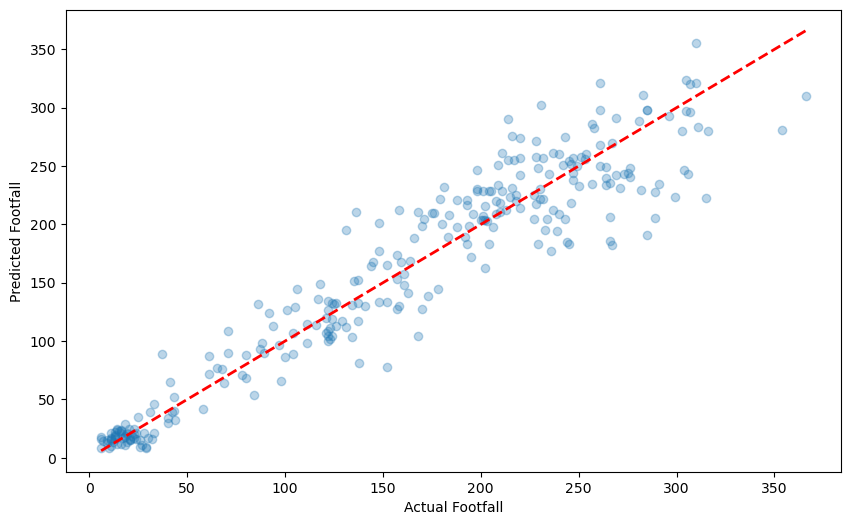


Performing analysis for Device 1833:
Mean Squared Error (Footfall only) for Device 1833: 604.6931823711316


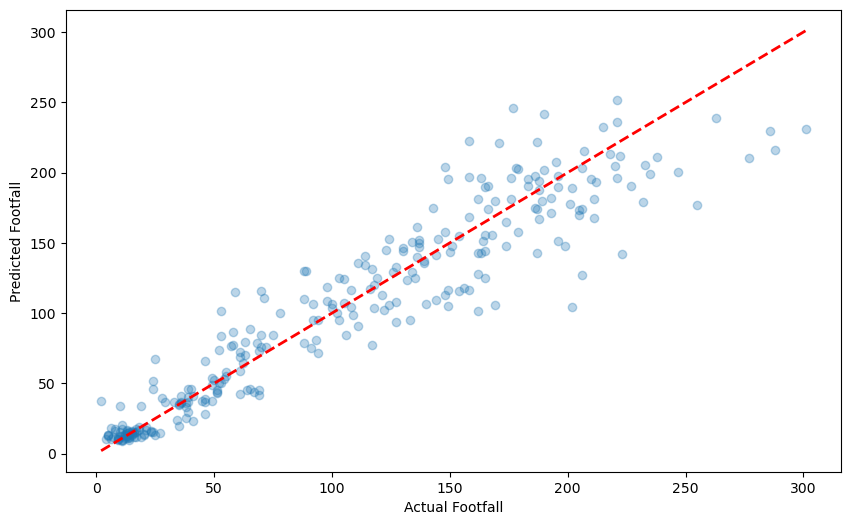

{1018: 846.2871658989662, 1833: 604.6931823711316}


In [75]:
# Initialize dictionaries to store MSE values, predictions, and test data for each device
mse_footfall_station = {}
y_test_footfall_station = {}
y_pred_footfall_station = {}

for index, device_info in devices_near_station.iterrows():
    device_id = device_info['device']
    print(f"\nPerforming analysis for Device {device_id}:")

    # Filter footfall data for the specific device within the first week of October
    df_device_footfall = first_week_october_data[first_week_october_data['device'] == device_id].copy()

    # Create lag features for footfall data
    for lag in range(1, 25):
        df_device_footfall[f'lag_{lag}'] = df_device_footfall['footfall'].shift(lag)

    # Drop rows with missing values due to lagging
    df_device_footfall.dropna(inplace=True)

    # Define features (X) and target (y)
    X_footfall_station = df_device_footfall[[col for col in df_device_footfall.columns if col.startswith('lag_')]]
    y_footfall_station = df_device_footfall['footfall']

    # Split the data into training and testing sets
    X_footfall_station_train, X_footfall_station_test, y_footfall_station_train, y_footfall_station_test = train_test_split(
        X_footfall_station, y_footfall_station, test_size=0.2, random_state=42, shuffle=False
    )

    # Train the model using XGBoost and make predictions
    dtrain_footfall_station = xgb.DMatrix(X_footfall_station_train, label=y_footfall_station_train)
    dtest_footfall_station = xgb.DMatrix(X_footfall_station_test, label=y_footfall_station_test)

    # Train the XGBoost model
    bst_footfall_station = xgb.train(params, dtrain_footfall_station, num_boost_round=100)

    # Predict footfall using the test dataset
    y_pred_footfall_station[device_id] = bst_footfall_station.predict(dtest_footfall_station)
    y_test_footfall_station[device_id] = y_footfall_station_test  # Store the actual test values

    # Calculate and display the Mean Squared Error
    mse_footfall_station[device_id] = mean_squared_error(y_footfall_station_test, y_pred_footfall_station[device_id])
    print(f'Mean Squared Error (Footfall only) for Device {device_id}: {mse_footfall_station[device_id]}')

    # Visualize the actual vs predicted footfall
    plt.figure(figsize=(10, 6))
    plt.scatter(y_footfall_station_test, y_pred_footfall_station[device_id], alpha=0.3)
    plt.plot([y_footfall_station_test.min(), y_footfall_station_test.max()], 
             [y_footfall_station_test.min(), y_footfall_station_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Footfall')
    plt.ylabel('Predicted Footfall')

    # Save the plot as an image file with device ID in the filename
    plt.savefig(f'./figures/actual_vs_predicted_footfall_device_{device_id}.png', bbox_inches='tight')

    # Show the plot
    plt.show()

# Print the dictionary with MSE values
print(mse_footfall_station)

In [76]:
print(f"Average MSE across all devices: {average_mse_footfall_initial}")

for device, mse_value in mse_footfall_station.items():
    print(f"\nMSE for Device {device}: {mse_value}")

Average MSE across all devices: 630.5964143467471

MSE for Device 1018: 846.2871658989662

MSE for Device 1833: 604.6931823711316


### 6.3 Analysis with Temperature Data for Each Device

#### 6.3.1 Temperature Data with Hourly Aggregation

In [77]:
# Define location for weather data (Holborn Station)
holborn_station = Point(51.51742, -0.11925)

# Define the date range for the first week of October 2018 (Monday to Friday)
start = datetime(2018, 10, 1)
end = datetime(2018, 10, 5)

# Fetch daily weather data (temperature and precipitation)
weather_data_holborn = Daily(holborn_station, start, end)
weather_data_holborn = weather_data_holborn.fetch()

# Keep only average temperature ('tavg') and precipitation ('prcp') columns
weather_data_holborn = weather_data_holborn[['tavg', 'prcp']]

# Reset index to bring the date into a column
weather_data_no_aggregation = weather_data_holborn.reset_index()

# Separate 'timestamp' into 'date' and 'time' columns
weather_data_no_aggregation['timestamp'] = pd.to_datetime(weather_data_no_aggregation['time'])
weather_data_no_aggregation['date'] = weather_data_no_aggregation['timestamp'].dt.date
weather_data_no_aggregation['time'] = weather_data_no_aggregation['timestamp'].dt.time

# Drop the original 'timestamp' column if not needed
temperature_data_no_aggregation = weather_data_no_aggregation[['date', 'time', 'tavg']]

print("Temperature Data (No Aggregation):")
print(temperature_data_no_aggregation.head())

Temperature Data (No Aggregation):
         date      time  tavg
0  2018-10-01  00:00:00  11.8
1  2018-10-02  00:00:00  16.0
2  2018-10-03  00:00:00  16.1
3  2018-10-04  00:00:00  14.0
4  2018-10-05  00:00:00  15.3


In [78]:
# Resample weather data to an hourly frequency and forward fill the temperature data
weather_data_holborn_hourly = weather_data_holborn.resample('H').ffill()

# Reset index to bring the date into a column
weather_data_hourly_aggregated = weather_data_holborn_hourly.reset_index()

# Separate 'timestamp' into 'date' and 'time' columns for consistency
weather_data_hourly_aggregated['timestamp'] = pd.to_datetime(weather_data_hourly_aggregated['time'])
weather_data_hourly_aggregated['date'] = weather_data_hourly_aggregated['timestamp'].dt.date
weather_data_hourly_aggregated['time'] = weather_data_hourly_aggregated['timestamp'].dt.time

# Drop the original 'timestamp' column if not needed
temperature_data_hourly_aggregated = weather_data_hourly_aggregated[['date', 'time', 'tavg']]

print("Temperature Data (Hourly Aggregation):")
print(temperature_data_hourly_aggregated.head())

Temperature Data (Hourly Aggregation):
         date      time  tavg
0  2018-10-01  00:00:00  11.8
1  2018-10-01  01:00:00  11.8
2  2018-10-01  02:00:00  11.8
3  2018-10-01  03:00:00  11.8
4  2018-10-01  04:00:00  11.8



Performing analysis with hourly aggregated temperature data for Device 1018:
Mean Squared Error (Footfall + Temperature with hourly aggregation) for Device 1018: 2139.54050181718


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


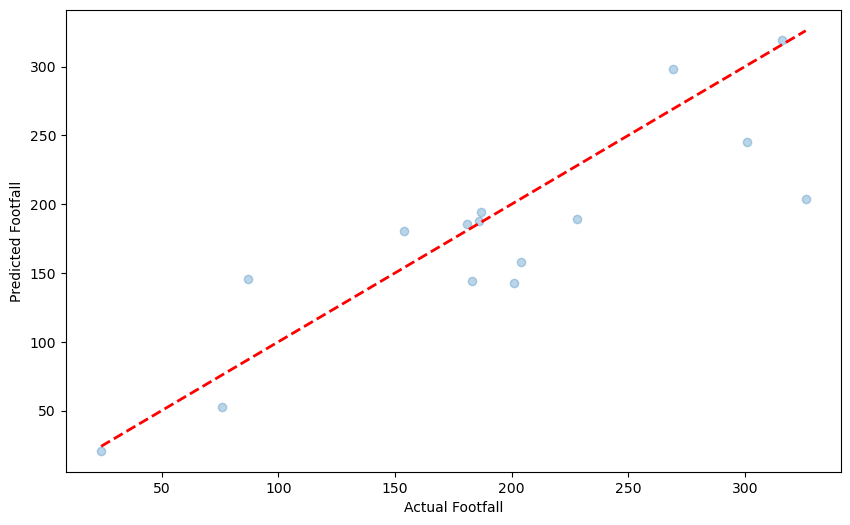


Performing analysis with hourly aggregated temperature data for Device 1833:
Mean Squared Error (Footfall + Temperature with hourly aggregation) for Device 1833: 991.8903546250319


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


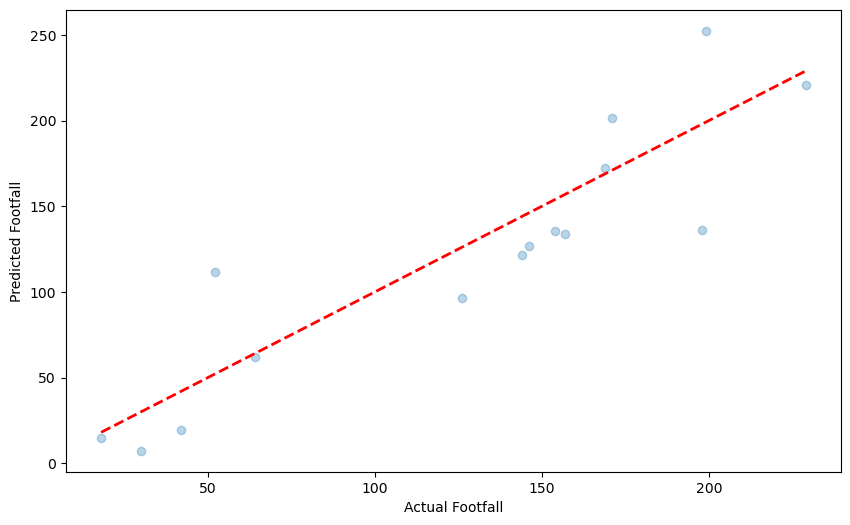

{1018: 2139.54050181718, 1833: 991.8903546250319}


In [79]:
# Initialize dictionaries to store MSE values, predictions, and test data for each device
mse_temp_hourly_aggregation_station = {}
y_test_temp_hourly_agg_station = {}
y_pred_temp_hourly_agg_station = {}

for index, device_info in devices_near_station.iterrows():
    device_id = device_info['device']
    print(f"\nPerforming analysis with hourly aggregated temperature data for Device {device_id}:")

    # Filter footfall data for the specific device
    df_device_footfall = first_week_october[first_week_october['device'] == device_id]

    # Ensure the 'date' column in df_device_footfall is in correct datetime format
    df_device_footfall['date'] = pd.to_datetime(df_device_footfall['date']).dt.date

    # Check if the 'time' column is already in datetime.time format
    if df_device_footfall['time'].dtype != 'object':
        df_device_footfall['time'] = df_device_footfall['time'].apply(lambda x: x.strftime('%H:%M:%S'))

    # Convert 'time' to datetime.time format if necessary
    df_device_footfall['time'] = pd.to_datetime(df_device_footfall['time'], format='%H:%M:%S').dt.time

    # Merge the device's footfall data with the temperature data
    df_device_footfall_temp = pd.merge(
        df_device_footfall, 
        temperature_data_hourly_aggregated[['date', 'time', 'tavg']], 
        how='inner', 
        on=['date', 'time']
    )

    # Create lag features for footfall data
    for lag in range(1, 25):
        df_device_footfall_temp[f'lag_{lag}'] = df_device_footfall_temp['footfall'].shift(lag)

    # Drop rows with missing values due to lagging
    df_device_footfall_temp = df_device_footfall_temp.dropna()

    # Define features (X) including lag features and temperature
    X_temp_hourly_agg_station = df_device_footfall_temp[[col for col in df_device_footfall_temp.columns if col.startswith('lag_')] + ['tavg']]
    y_temp_hourly_agg_station = df_device_footfall_temp['footfall']

    # Split the data into training and testing sets
    X_temp_hourly_agg_station_train, X_temp_hourly_agg_station_test, y_temp_hourly_agg_station_train, y_temp_hourly_agg_station_test = train_test_split(
        X_temp_hourly_agg_station, y_temp_hourly_agg_station, test_size=0.2, random_state=42, shuffle=False
    )

    # Train the model with footfall + temperature
    dtrain_temp_hourly_agg_station = xgb.DMatrix(X_temp_hourly_agg_station_train, label=y_temp_hourly_agg_station_train)
    dtest_temp_hourly_agg_station = xgb.DMatrix(X_temp_hourly_agg_station_test, label=y_temp_hourly_agg_station_test)

    # Train and predict using the XGBoost model
    bst_temp_hourly_agg_station = xgb.train(params, dtrain_temp_hourly_agg_station, num_boost_round=100)
    y_pred_temp_hourly_agg_station[device_id] = bst_temp_hourly_agg_station.predict(dtest_temp_hourly_agg_station)
    y_test_temp_hourly_agg_station[device_id] = y_temp_hourly_agg_station_test  # Store the actual test values

    # Calculate and store the Mean Squared Error
    mse_temp_hourly_aggregation_station[device_id] = mean_squared_error(y_temp_hourly_agg_station_test, y_pred_temp_hourly_agg_station[device_id])
    print(f'Mean Squared Error (Footfall + Temperature with hourly aggregation) for Device {device_id}: {mse_temp_hourly_aggregation_station[device_id]}')

    # Visualize the results
    plt.figure(figsize=(10, 6))
    plt.scatter(y_temp_hourly_agg_station_test, y_pred_temp_hourly_agg_station[device_id], alpha=0.3)
    plt.plot([y_temp_hourly_agg_station_test.min(), y_temp_hourly_agg_station_test.max()], 
             [y_temp_hourly_agg_station_test.min(), y_temp_hourly_agg_station_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Footfall')
    plt.ylabel('Predicted Footfall')

    # Save the plot as an image file with device ID in the filename
    plt.savefig(f'./figures/footfall_prediction_temp_hourly_aggregation_device_{device_id}.png', bbox_inches='tight')

    # Show the plot
    plt.show()

# Print the dictionary with MSE values
print(mse_temp_hourly_aggregation_station)

#### 6.3.2 Temperature Data without Aggregation


Performing analysis with original weather data (no aggregation) for Device 1018:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Mean Squared Error (Footfall + Temperature without aggregation) for Device 1018: 856.098947520755


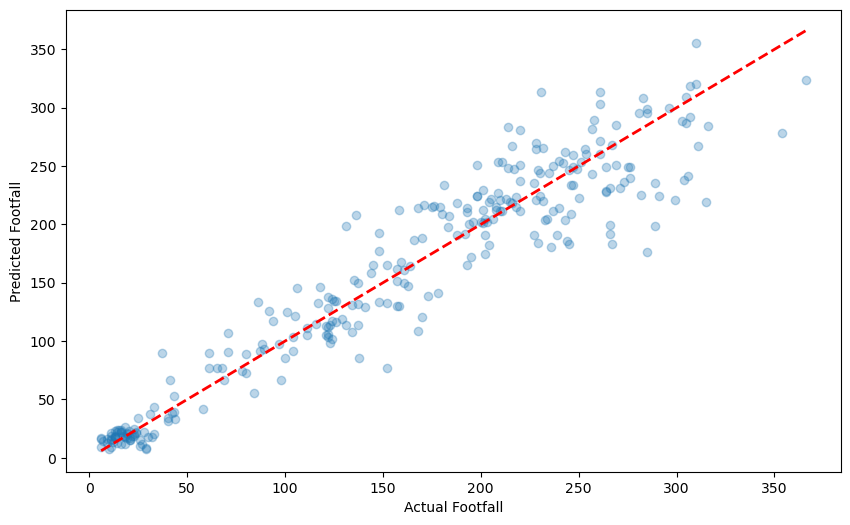


Performing analysis with original weather data (no aggregation) for Device 1833:
Mean Squared Error (Footfall + Temperature without aggregation) for Device 1833: 633.852268978878


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


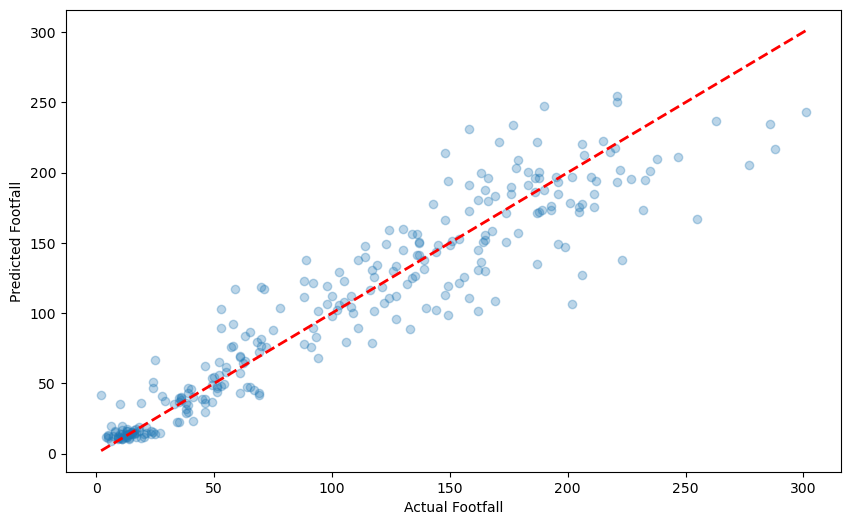

{1018: 856.098947520755, 1833: 633.852268978878}


In [80]:
# Initialize dictionaries to store MSE values, predictions, and test data for each device
mse_temp_no_aggregation_station = {}
y_test_temp_no_agg_station = {}
y_pred_temp_no_agg_station = {}

for index, device_info in devices_near_station.iterrows():
    device_id = device_info['device']
    print(f"\nPerforming analysis with original weather data (no aggregation) for Device {device_id}:")

    # Filter footfall data for the specific device
    df_device_footfall = first_week_october[first_week_october['device'] == device_id]

    # Ensure the 'date' column in df_device_footfall is in datetime format
    df_device_footfall['date'] = pd.to_datetime(df_device_footfall['date']).dt.date

    # Merge the device's footfall data with the temperature data
    df_device_footfall_temp = pd.merge(
        df_device_footfall, 
        temperature_data_no_aggregation[['date', 'tavg']], 
        how='inner', 
        on='date'
    )

    # Create lag features for footfall data
    for lag in range(1, 25):
        df_device_footfall_temp[f'lag_{lag}'] = df_device_footfall_temp['footfall'].shift(lag)

    # Drop rows with missing values due to lagging
    df_device_footfall_temp = df_device_footfall_temp.dropna()

    # Define features (X) including lag features and temperature
    X_temp_no_agg_station = df_device_footfall_temp[[col for col in df_device_footfall_temp.columns if col.startswith('lag_')] + ['tavg']]
    y_temp_no_agg_station = df_device_footfall_temp['footfall']

    # Split the data into training and testing sets
    X_temp_no_agg_station_train, X_temp_no_agg_station_test, y_temp_no_agg_station_train, y_temp_no_agg_station_test = train_test_split(
        X_temp_no_agg_station, y_temp_no_agg_station, test_size=0.2, random_state=42, shuffle=False
    )

    # Train the model with footfall + temperature
    dtrain_temp_no_agg_station = xgb.DMatrix(X_temp_no_agg_station_train, label=y_temp_no_agg_station_train)
    dtest_temp_no_agg_station = xgb.DMatrix(X_temp_no_agg_station_test, label=y_temp_no_agg_station_test)

    # Train and predict using the XGBoost model
    bst_temp_no_agg_station = xgb.train(params, dtrain_temp_no_agg_station, num_boost_round=100)
    y_pred_temp_no_agg_station[device_id] = bst_temp_no_agg_station.predict(dtest_temp_no_agg_station)
    y_test_temp_no_agg_station[device_id] = y_temp_no_agg_station_test  # Store the actual test values

    # Calculate and store the Mean Squared Error
    mse_temp_no_aggregation_station[device_id] = mean_squared_error(y_temp_no_agg_station_test, y_pred_temp_no_agg_station[device_id])
    print(f'Mean Squared Error (Footfall + Temperature without aggregation) for Device {device_id}: {mse_temp_no_aggregation_station[device_id]}')

    # Visualize the results
    plt.figure(figsize=(10, 6))
    plt.scatter(y_temp_no_agg_station_test, y_pred_temp_no_agg_station[device_id], alpha=0.3)
    plt.plot([y_temp_no_agg_station_test.min(), y_temp_no_agg_station_test.max()], 
             [y_temp_no_agg_station_test.min(), y_temp_no_agg_station_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Footfall')
    plt.ylabel('Predicted Footfall')

    # Save the plot as an image file with device ID in the filename
    plt.savefig(f'./figures/actual_vs_predicted_footfall_prediction_temp_no_aggregation_device_{device_id}.png', bbox_inches='tight')

    # Show the plot
    plt.show()

# Print the dictionary with MSE values
print(mse_temp_no_aggregation_station)

In [81]:
# Print the average MSE
print(f"Average MSE for incorporating Temperature Data with hourly aggregation: {average_mse_temp_initial}")

# Print the dictionary with MSE values after hourly aggregation
print("\nMSE values with hourly aggregation:")
for device, mse_value in mse_temp_hourly_aggregation_station.items():
    print(f"Device {device}: MSE = {mse_value}")

# Print the dictionary with MSE values without aggregation
print("\nMSE values without aggregation:")
for device, mse_value in mse_temp_no_aggregation_station.items():
    print(f"Device {device}: MSE = {mse_value}")

Average MSE for incorporating Temperature Data with hourly aggregation: 1229.4395595825156

MSE values with hourly aggregation:
Device 1018: MSE = 2139.54050181718
Device 1833: MSE = 991.8903546250319

MSE values without aggregation:
Device 1018: MSE = 856.098947520755
Device 1833: MSE = 633.852268978878


### 6.4 Analysis with Temperature and Precipitation Data for Each Device

#### 6.4.1 Temperature and Precipitation Data with Hourly Aggregation


Performing analysis with hourly aggregated temperature and precipitation data for Device 1018:
Mean Squared Error (Footfall + Temperature + Precipitation with hourly aggregation) for Device 1018: 2139.54050181718


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


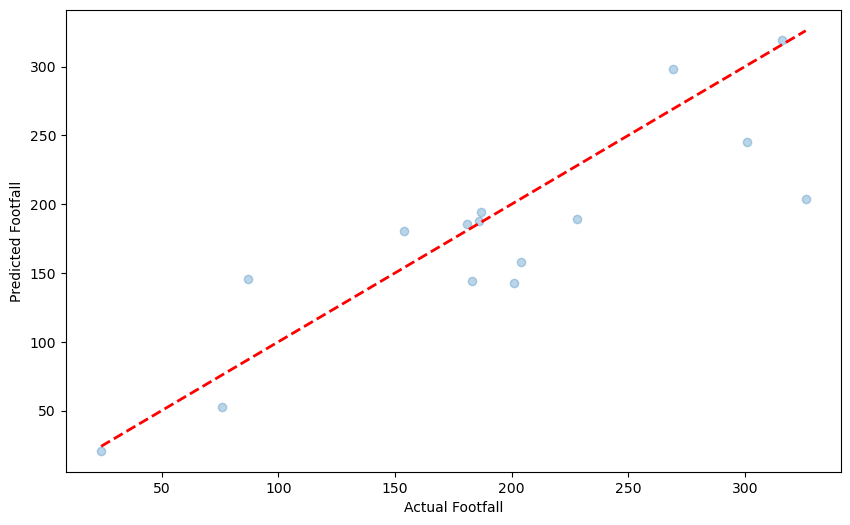


Performing analysis with hourly aggregated temperature and precipitation data for Device 1833:
Mean Squared Error (Footfall + Temperature + Precipitation with hourly aggregation) for Device 1833: 991.8903546250319


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


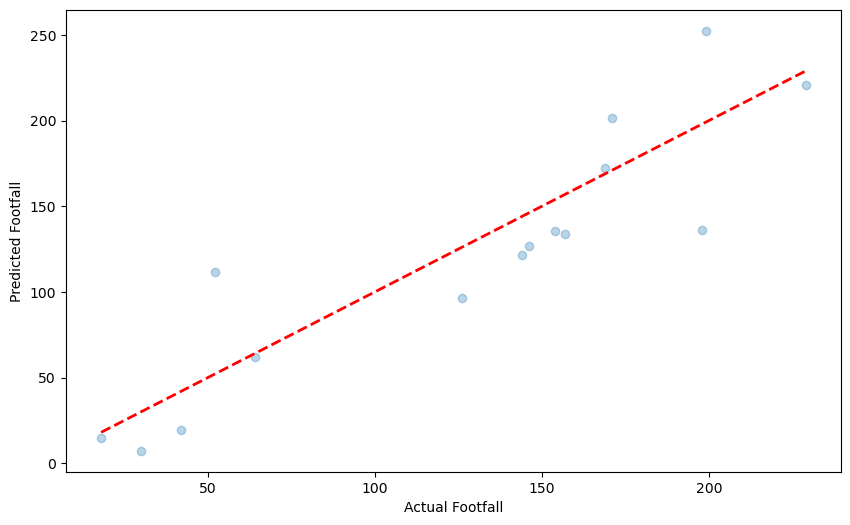

{1018: 2139.54050181718, 1833: 991.8903546250319}


In [82]:
# Initialize dictionaries to store MSE values, predictions, and test data for each device
mse_temp_prcp_hourly_aggregation_station = {}
y_test_temp_prcp_hourly_agg_station = {}
y_pred_temp_prcp_hourly_agg_station = {}

for index, device_info in devices_near_station.iterrows():
    device_id = device_info['device']
    print(f"\nPerforming analysis with hourly aggregated temperature and precipitation data for Device {device_id}:")

    # Filter footfall data for the specific device
    df_device_footfall = first_week_october[first_week_october['device'] == device_id]

    # Ensure the 'date' column in df_device_footfall is in correct datetime format
    df_device_footfall['date'] = pd.to_datetime(df_device_footfall['date']).dt.date

    # Check if the 'time' column is already in datetime.time format
    if df_device_footfall['time'].dtype != 'object':
        df_device_footfall['time'] = df_device_footfall['time'].apply(lambda x: x.strftime('%H:%M:%S'))

    # Convert 'time' to datetime.time format if necessary
    df_device_footfall['time'] = pd.to_datetime(df_device_footfall['time'], format='%H:%M:%S').dt.time

    # Merge the device's footfall data with the temperature and precipitation data
    df_device_footfall_temp_prcp = pd.merge(
        df_device_footfall, 
        weather_data_hourly_aggregated[['date', 'time', 'tavg', 'prcp']], 
        how='inner', 
        on=['date', 'time']
    )

    # Create lag features for footfall data
    for lag in range(1, 25):
        df_device_footfall_temp_prcp[f'lag_{lag}'] = df_device_footfall_temp_prcp['footfall'].shift(lag)

    # Drop rows with missing values due to lagging
    df_device_footfall_temp_prcp = df_device_footfall_temp_prcp.dropna()

    # Define features (X) including lag features, temperature, and precipitation
    X_temp_prcp_hourly_agg_station = df_device_footfall_temp_prcp[
        [col for col in df_device_footfall_temp_prcp.columns if col.startswith('lag_')] + ['tavg', 'prcp']
    ]
    y_temp_prcp_hourly_agg_station = df_device_footfall_temp_prcp['footfall']

    # Split the data into training and testing sets
    X_temp_prcp_hourly_agg_station_train, X_temp_prcp_hourly_agg_station_test, y_temp_prcp_hourly_agg_station_train, y_temp_prcp_hourly_agg_station_test = train_test_split(
        X_temp_prcp_hourly_agg_station, y_temp_prcp_hourly_agg_station, test_size=0.2, random_state=42, shuffle=False
    )

    # Train the model with footfall + temperature + precipitation
    dtrain_temp_prcp_hourly_agg_station = xgb.DMatrix(X_temp_prcp_hourly_agg_station_train, label=y_temp_prcp_hourly_agg_station_train)
    dtest_temp_prcp_hourly_agg_station = xgb.DMatrix(X_temp_prcp_hourly_agg_station_test, label=y_temp_prcp_hourly_agg_station_test)

    # Train and predict using the XGBoost model
    bst_temp_prcp_hourly_agg_station = xgb.train(params, dtrain_temp_prcp_hourly_agg_station, num_boost_round=100)
    y_pred_temp_prcp_hourly_agg_station[device_id] = bst_temp_prcp_hourly_agg_station.predict(dtest_temp_prcp_hourly_agg_station)
    y_test_temp_prcp_hourly_agg_station[device_id] = y_temp_prcp_hourly_agg_station_test  # Store the actual test values

    # Calculate and display the Mean Squared Error
    mse_temp_prcp_hourly_aggregation_station[device_id] = mean_squared_error(y_temp_prcp_hourly_agg_station_test, y_pred_temp_prcp_hourly_agg_station[device_id])
    print(f'Mean Squared Error (Footfall + Temperature + Precipitation with hourly aggregation) for Device {device_id}: {mse_temp_prcp_hourly_aggregation_station[device_id]}')

    # Visualize the results
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_temp_prcp_hourly_agg_station[device_id], y_pred_temp_prcp_hourly_agg_station[device_id], alpha=0.3)
    plt.plot([y_test_temp_prcp_hourly_agg_station[device_id].min(), y_test_temp_prcp_hourly_agg_station[device_id].max()], 
             [y_test_temp_prcp_hourly_agg_station[device_id].min(), y_test_temp_prcp_hourly_agg_station[device_id].max()], 'r--', lw=2)
    plt.xlabel('Actual Footfall')
    plt.ylabel('Predicted Footfall')

    # Save the plot as an image file with device ID in the filename
    plt.savefig(f'./figures/footfall_prediction_temp_prcp_device_with_Hourly_Aggregation_{device_id}.png', bbox_inches='tight')

    # Show the plot
    plt.show()

# Print the dictionary with MSE values
print(mse_temp_prcp_hourly_aggregation_station)

#### 6.4.2 Temperature and Precipitation Data without Aggregation


Performing analysis with temperature and precipitation data (no aggregation) for Device 1018:
Mean Squared Error (Footfall + Temperature + Precipitation) for Device 1018: 856.098947520755


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


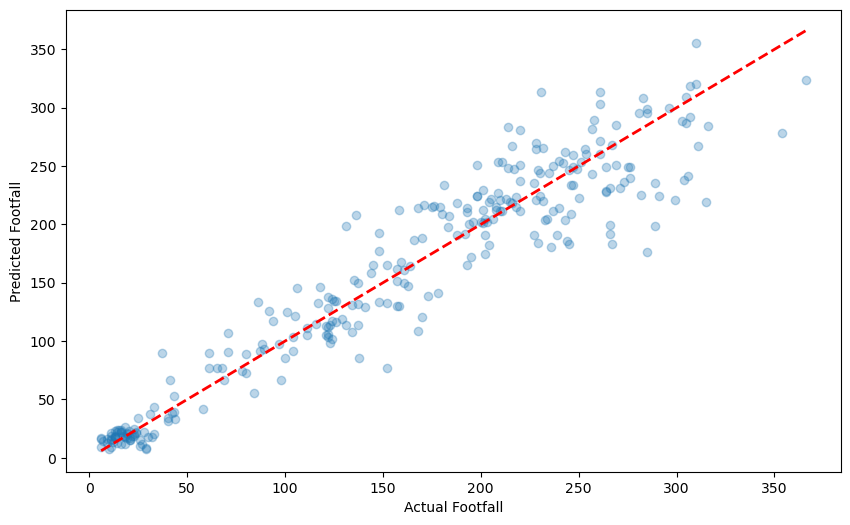


Performing analysis with temperature and precipitation data (no aggregation) for Device 1833:
Mean Squared Error (Footfall + Temperature + Precipitation) for Device 1833: 633.852268978878


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


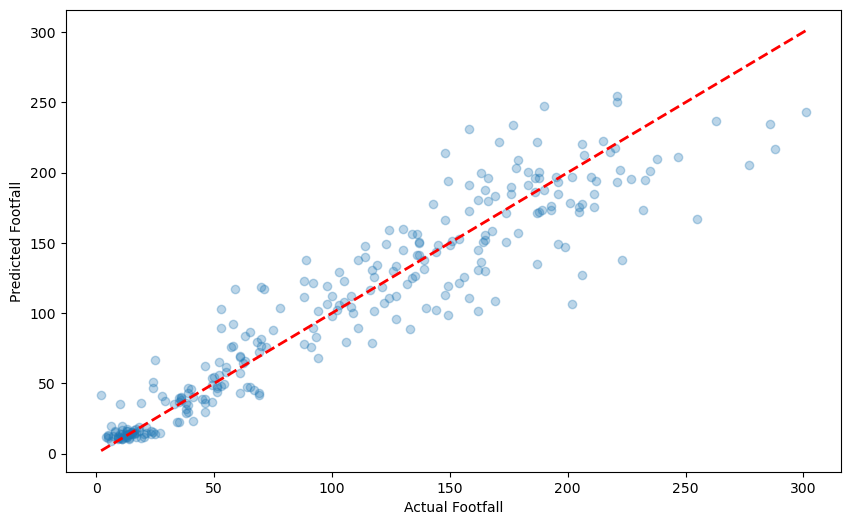

{1018: 856.098947520755, 1833: 633.852268978878}


In [83]:
# Initialize dictionaries to store MSE values, predictions, and test data for each device
mse_temp_prcp_no_aggregation_station = {}
y_test_temp_prcp_no_agg_station = {}
y_pred_temp_prcp_no_agg_station = {}

for index, device_info in devices_near_station.iterrows():
    device_id = device_info['device']
    print(f"\nPerforming analysis with temperature and precipitation data (no aggregation) for Device {device_id}:")

    # Filter footfall data for the specific device
    df_device_footfall = first_week_october[first_week_october['device'] == device_id]

    # Ensure the 'date' column in df_device_footfall is in datetime format
    df_device_footfall['date'] = pd.to_datetime(df_device_footfall['date']).dt.date

    # Re-merge the device's footfall data with the temperature data from the second stage
    df_device_footfall_temp = pd.merge(
        df_device_footfall,
        temperature_data_no_aggregation[['date', 'tavg']],
        how='inner',
        on='date'
    )

    # Now merge this with precipitation data from the original weather data
    df_device_footfall_temp_prcp_no_aggregation = pd.merge(
        df_device_footfall_temp,
        weather_data_no_aggregation[['date', 'prcp']],
        how='inner',
        on='date'
    )

    # Create lag features for footfall data
    for lag in range(1, 25):
        df_device_footfall_temp_prcp_no_aggregation[f'lag_{lag}'] = df_device_footfall_temp_prcp_no_aggregation['footfall'].shift(lag)

    # Drop rows with missing values due to lagging
    df_device_footfall_temp_prcp_no_aggregation = df_device_footfall_temp_prcp_no_aggregation.dropna()

    # Define features (X) including lag features, temperature, and precipitation
    X_temp_prcp_no_agg_station = df_device_footfall_temp_prcp_no_aggregation[
        [col for col in df_device_footfall_temp_prcp_no_aggregation.columns if col.startswith('lag_')] + ['tavg', 'prcp']
    ]
    y_temp_prcp_no_agg_station = df_device_footfall_temp_prcp_no_aggregation['footfall']

    # Split the data into training and testing sets
    X_temp_prcp_no_agg_station_train, X_temp_prcp_no_agg_station_test, y_temp_prcp_no_agg_station_train, y_temp_prcp_no_agg_station_test = train_test_split(
        X_temp_prcp_no_agg_station, y_temp_prcp_no_agg_station, test_size=0.2, random_state=42, shuffle=False
    )

    # Train the model with footfall + temperature + precipitation
    dtrain_temp_prcp_no_agg_station = xgb.DMatrix(X_temp_prcp_no_agg_station_train, label=y_temp_prcp_no_agg_station_train)
    dtest_temp_prcp_no_agg_station = xgb.DMatrix(X_temp_prcp_no_agg_station_test, label=y_temp_prcp_no_agg_station_test)

    # Train and predict using the XGBoost model
    bst_temp_prcp_no_agg_station = xgb.train(params, dtrain_temp_prcp_no_agg_station, num_boost_round=100)
    y_pred_temp_prcp_no_agg_station[device_id] = bst_temp_prcp_no_agg_station.predict(dtest_temp_prcp_no_agg_station)
    y_test_temp_prcp_no_agg_station[device_id] = y_temp_prcp_no_agg_station_test  # Store the actual test values

    # Calculate and store the Mean Squared Error
    mse_temp_prcp_no_aggregation_station[device_id] = mean_squared_error(y_temp_prcp_no_agg_station_test, y_pred_temp_prcp_no_agg_station[device_id])
    print(f'Mean Squared Error (Footfall + Temperature + Precipitation) for Device {device_id}: {mse_temp_prcp_no_aggregation_station[device_id]}')

    # Visualize the results
    plt.figure(figsize=(10, 6))
    plt.scatter(y_temp_prcp_no_agg_station_test, y_pred_temp_prcp_no_agg_station[device_id], alpha=0.3)
    plt.plot([y_temp_prcp_no_agg_station_test.min(), y_temp_prcp_no_agg_station_test.max()], 
             [y_temp_prcp_no_agg_station_test.min(), y_temp_prcp_no_agg_station_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Footfall')
    plt.ylabel('Predicted Footfall')

    # Save the plot as an image file with device ID in the filename
    plt.savefig(f'./figures/footfall_prediction_temp_prcp_device_{device_id}_no_aggregation.png', bbox_inches='tight')

    # Show the plot
    plt.show()

# Print the dictionary with MSE values
print(mse_temp_prcp_no_aggregation_station)

In [84]:
# Print the average MSE
print(f"Average MSE for incorporating Temperature and Precipitation Data: {average_mse_temp_prcp_initial}")

# Analysis with Temperature and Precipitation Data
print("\nMSE values with hourly aggregation:")
for device, mse_value in mse_temp_prcp_hourly_aggregation_station.items():
    print(f"Device {device}: MSE = {mse_value}")

print("\nMSE values without aggregation:")
for device, mse_value in mse_temp_prcp_no_aggregation_station.items():
    print(f"Device {device}: MSE = {mse_value}")

Average MSE for incorporating Temperature and Precipitation Data: 1220.2351856986272

MSE values with hourly aggregation:
Device 1018: MSE = 2139.54050181718
Device 1833: MSE = 991.8903546250319

MSE values without aggregation:
Device 1018: MSE = 856.098947520755
Device 1833: MSE = 633.852268978878


### 6.5 Analysis with Full Model (Add TfL Data) for Each Device

#### 6.5.1 Load, Clean and Filter TFL Data

In [85]:
conn = sqlite3.connect(sqlite_db_path)

tfl_data_path = os.path.join(current_dir, 'rawdata', 'TFL_data.xlsx')

# Load the second worksheet in the Excel file, skipping the first 6 rows to get to the actual data
df_tfl = pd.read_excel(tfl_data_path, sheet_name=1, skiprows=6)

# Retain useful columns
excluded_columns = ['Mode', 'ASC', 'Coverage', 'year', 'Total', 'Early', 'AM Peak', 'Inter Peak', 'PM Peak', 'Evening', 'Late']
time_columns = [col for col in df_tfl.columns if col not in excluded_columns]
df_tfl = df_tfl[time_columns]

# Print columns to verify
print("Columns in df_tfl:", df_tfl.columns)

Columns in df_tfl: Index(['NLC', 'Station', ' day', ' dir', 'Early     ', 'Evening   ',
       'Late      ', '0500-0515', '0515-0530', '0530-0545',
       ...
       '0230-0245', '0245-0300', '0300-0315', '0315-0330', '0330-0345',
       '0345-0400', '0400-0415', '0415-0430', '0430-0445', '0445-0500'],
      dtype='object', length=103)


In [86]:
# Rename columns to ensure consistency
df_tfl = df_tfl.rename(columns={' day': 'day', ' dir': 'dir'})

# Remove rows with missing values in key columns
df_tfl = df_tfl.dropna(subset=['NLC', 'Station'])

# Print data to verify
print(df_tfl.head())

   NLC       Station  day dir  Early       Evening     Late        0500-0515  \
0  500    Acton Town  MTT  IN         628         574         192         26   
1  502       Aldgate  MTT  IN         278        1781         373         10   
2  503  Aldgate East  MTT  IN         306        3175        1030          1   
3  505      Alperton  MTT  IN         579         301          99          9   
4  506      Amersham  MTT  IN         578          82          26          4   

   0515-0530  0530-0545  ...  0230-0245  0245-0300  0300-0315  0315-0330  \
0         32         38  ...          0          0          0          0   
1          9          5  ...          0          0          0          0   
2         22         22  ...          0          0          0          0   
3         28         35  ...          0          0          0          0   
4         12         52  ...          0          0          0          0   

   0330-0345  0345-0400  0400-0415  0415-0430  0430-0445  0445

In [87]:
# Reshape TfL data to long format, focusing on the time intervals
df_tfl_long = df_tfl.melt(id_vars=['NLC', 'Station', 'day', 'dir'], var_name='time', value_name='count')

# Filter out rows where 'time' does not match the expected format (e.g., "0500-0515")
df_tfl_long = df_tfl_long[df_tfl_long['time'].str.match(r'^\d{4}-\d{4}$')]

# Convert the 'time' column to a consistent format (HH:MM-HH:MM) for merging purposes
def format_time_interval(time_str):
    start_time = time_str.split('-')[0]
    end_time = time_str.split('-')[1]
    return f"{start_time[:2]}:{start_time[2:]}-{end_time[:2]}:{end_time[2:]}"

# Apply the time interval formatting to create a 'formatted_time' column
df_tfl_long['formatted_time'] = df_tfl_long['time'].apply(format_time_interval)

# Display a sample of the formatted data
print("Sample of formatted TfL data:")
print(df_tfl_long.head())

Sample of formatted TfL data:
       NLC       Station  day dir       time  count formatted_time
10752  500    Acton Town  MTT  IN  0500-0515     26    05:00-05:15
10753  502       Aldgate  MTT  IN  0500-0515     10    05:00-05:15
10754  503  Aldgate East  MTT  IN  0500-0515      1    05:00-05:15
10755  505      Alperton  MTT  IN  0500-0515      9    05:00-05:15
10756  506      Amersham  MTT  IN  0500-0515      4    05:00-05:15


In [88]:
# Group the data by necessary columns and aggregate the counts for each interval
df_tfl_grouped = df_tfl_long.groupby(['Station', 'day', 'formatted_time']).agg({'count': 'sum'}).reset_index()

# Filter TfL data to include only records from the selected station (e.g., Holborn)
df_tfl_holborn = df_tfl_grouped[df_tfl_grouped['Station'] == selected_station['Station']]

# Filter data for Monday to Friday (MTT and FRI)
df_tfl_holborn_weekdays = df_tfl_holborn[df_tfl_holborn['day'].isin(['MTT', 'FRI'])]

# Display the filtered data
print("Filtered TfL data for Holborn station (Monday to Friday):")
print(df_tfl_holborn_weekdays[['Station', 'day', 'formatted_time', 'count']].head())

# Check the unique days in the filtered data to ensure the filtering is correct
unique_days_filtered = df_tfl_holborn_weekdays['day'].unique()
print("Unique days in the filtered TfL data:", unique_days_filtered)

Filtered TfL data for Holborn station (Monday to Friday):
       Station  day formatted_time  count
69504  Holborn  FRI    00:00-00:15    415
69505  Holborn  FRI    00:15-00:30    400
69506  Holborn  FRI    00:30-00:45    270
69507  Holborn  FRI    00:45-01:00    239
69508  Holborn  FRI    01:00-01:15    227
Unique days in the filtered TfL data: ['FRI' 'MTT']


In [89]:
# Version 1: Keep the original time intervals
df_tfl_holborn_original_intervals = df_tfl_holborn_weekdays[['Station', 'day', 'formatted_time', 'count']].copy()

# Version 2: Aggregate the data to 1-hour intervals
# Convert the formatted time to just the hour for aggregation
def convert_to_hour_interval(formatted_time):
    start_time = formatted_time.split('-')[0]
    return start_time[:2] + ":00"

df_tfl_holborn_weekdays['hourly_time'] = df_tfl_holborn_weekdays['formatted_time'].apply(convert_to_hour_interval)

# Group by Station, day, and the hourly interval, summing the counts
df_tfl_holborn_hourly_aggregated = df_tfl_holborn_weekdays.groupby(['Station', 'day', 'hourly_time']).agg({'count': 'sum'}).reset_index()

# Display the first few rows of each version
print("TfL data with original time intervals:")
print(df_tfl_holborn_original_intervals.head())

print("\nTfL data aggregated by 1-hour intervals:")
print(df_tfl_holborn_hourly_aggregated.head())

TfL data with original time intervals:
       Station  day formatted_time  count
69504  Holborn  FRI    00:00-00:15    415
69505  Holborn  FRI    00:15-00:30    400
69506  Holborn  FRI    00:30-00:45    270
69507  Holborn  FRI    00:45-01:00    239
69508  Holborn  FRI    01:00-01:15    227

TfL data aggregated by 1-hour intervals:
   Station  day hourly_time  count
0  Holborn  FRI       00:00   1324
1  Holborn  FRI       01:00    784
2  Holborn  FRI       02:00    480
3  Holborn  FRI       03:00    314
4  Holborn  FRI       04:00    175


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### 6.5.2 Expand TFL Data

In [90]:
# Create a mapping from 'day' to specific dates
day_to_date = {
    'FRI': [datetime(2018, 10, 5)],
    'MTT': [datetime(2018, 10, 1), datetime(2018, 10, 2), datetime(2018, 10, 3), datetime(2018, 10, 4)]
}

# Create an empty list to store expanded TfL data rows for original intervals
expanded_tfl_original = []

# Loop through df_tfl_holborn_original_intervals to map days to dates
for _, row in df_tfl_holborn_original_intervals.iterrows():
    if row['day'] in day_to_date:
        for date in day_to_date[row['day']]:
            row_copy = row.copy()
            row_copy['date'] = date
            expanded_tfl_original.append(row_copy)

# Convert the list to a DataFrame
expanded_tfl_original_df = pd.DataFrame(expanded_tfl_original)

# Ensure 'formatted_time' is split into separate 'start_time' and 'end_time' in datetime.time format
expanded_tfl_original_df['start_time'] = pd.to_datetime(expanded_tfl_original_df['formatted_time'].str.split('-').str[0], format='%H:%M').dt.time
expanded_tfl_original_df['end_time'] = pd.to_datetime(expanded_tfl_original_df['formatted_time'].str.split('-').str[1], format='%H:%M').dt.time

# Drop the 'day' and 'formatted_time' columns as they're no longer needed
expanded_tfl_original_df = expanded_tfl_original_df.drop(columns=['day', 'formatted_time'])

# Display the expanded DataFrame with original time intervals
print("Expanded TfL Data with Original Time Intervals:")
print(expanded_tfl_original_df.head())

Expanded TfL Data with Original Time Intervals:
       Station  count       date start_time  end_time
69504  Holborn    415 2018-10-05   00:00:00  00:15:00
69505  Holborn    400 2018-10-05   00:15:00  00:30:00
69506  Holborn    270 2018-10-05   00:30:00  00:45:00
69507  Holborn    239 2018-10-05   00:45:00  01:00:00
69508  Holborn    227 2018-10-05   01:00:00  01:15:00


In [91]:
# Create an empty list to store expanded TfL data rows for hourly aggregated intervals
expanded_tfl_hourly_aggregated = []

# Loop through df_tfl_holborn_hourly_aggregated to map days to dates
for _, row in df_tfl_holborn_hourly_aggregated.iterrows():
    if row['day'] in day_to_date:
        for date in day_to_date[row['day']]:
            row_copy = row.copy()
            row_copy['date'] = date
            expanded_tfl_hourly_aggregated.append(row_copy)

# Convert the list to a DataFrame
expanded_tfl_hourly_aggregated_df = pd.DataFrame(expanded_tfl_hourly_aggregated)

# Ensure 'hourly_time' is in datetime.time format
expanded_tfl_hourly_aggregated_df['hour'] = pd.to_datetime(expanded_tfl_hourly_aggregated_df['hourly_time'], format='%H:%M').dt.time

# Drop the 'day' and 'hourly_time' columns as they're no longer needed
expanded_tfl_hourly_aggregated_df = expanded_tfl_hourly_aggregated_df.drop(columns=['day', 'hourly_time'])

# Display the expanded DataFrame with hourly aggregated intervals
print("Expanded TfL Data with 1-Hour Aggregated Intervals:")
print(expanded_tfl_hourly_aggregated_df.head())

Expanded TfL Data with 1-Hour Aggregated Intervals:
   Station  count       date      hour
0  Holborn   1324 2018-10-05  00:00:00
1  Holborn    784 2018-10-05  01:00:00
2  Holborn    480 2018-10-05  02:00:00
3  Holborn    314 2018-10-05  03:00:00
4  Holborn    175 2018-10-05  04:00:00


#### 6.5.3 For Temperature, Precipitation and Transport Data all with Hourly Aggregation


Performing analysis with full model (temperature, precipitation, TfL data - hourly aggregation) for Device 1018:
Mean Squared Error (Full Model - Hourly Aggregation and Lag TFL) for Device 1018: 626.4828054891528


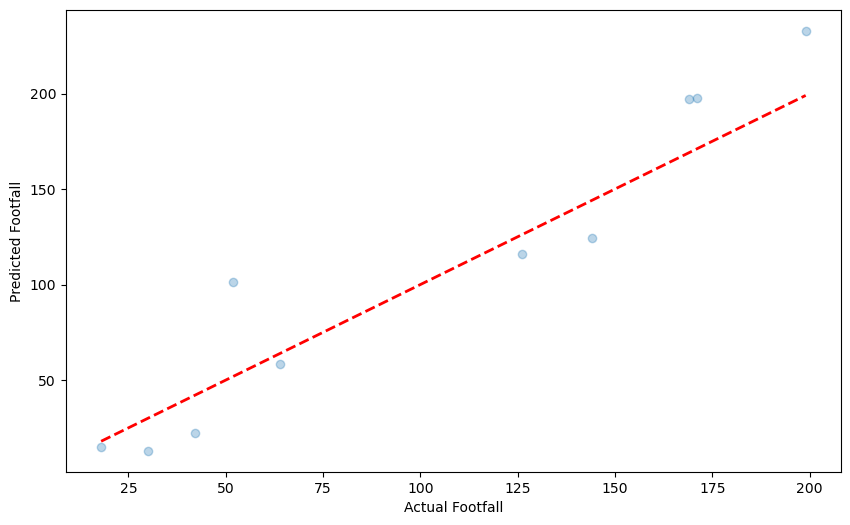


Performing analysis with full model (temperature, precipitation, TfL data - hourly aggregation) for Device 1833:
Mean Squared Error (Full Model - Hourly Aggregation and Lag TFL) for Device 1833: 626.4828054891528


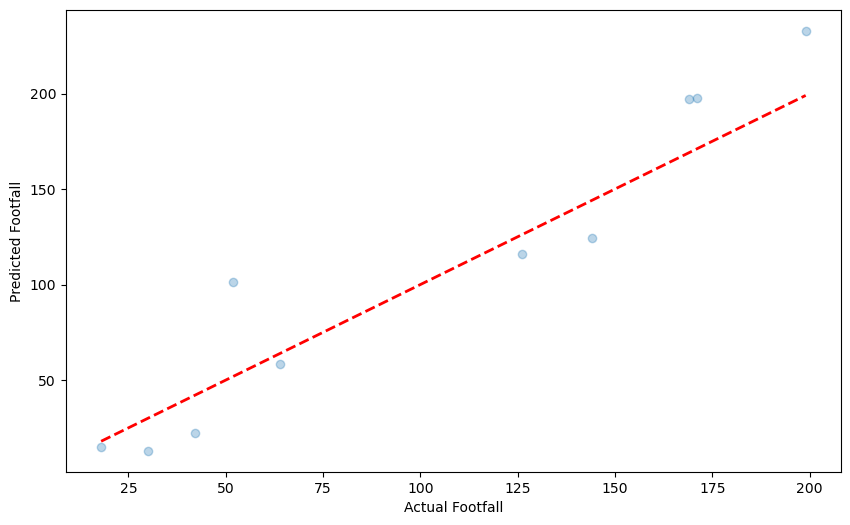

MSE values for all devices: {1018: 626.4828054891528, 1833: 626.4828054891528}


In [92]:
# Initialize dictionaries to store MSE values, predictions, and test data for each device
mse_full_hourly_agg_lagTFL_station = {}
y_test_full_hourly_agg_lagTFL_station = {}
y_pred_full_hourly_agg_lagTFL_station = {}

# Loop through each device near the selected station
for index, device_info in devices_near_station.iterrows():
    device_id = device_info['device']
    print(f"\nPerforming analysis with full model (temperature, precipitation, TfL data - hourly aggregation) for Device {device_id}:")

    # Use the df_device_footfall_temp_prcp dataset, which includes footfall + temperature + precipitation data
    df_device_full_model_hourly_agg = df_device_footfall_temp_prcp.copy()

    # Ensure the 'date' column in both DataFrames is in datetime64[ns] format for proper merging
    df_device_full_model_hourly_agg['date'] = pd.to_datetime(df_device_full_model_hourly_agg['date'])
    expanded_tfl_hourly_aggregated_df['date'] = pd.to_datetime(expanded_tfl_hourly_aggregated_df['date'])

    # Merge footfall, temperature, precipitation data with TfL data (hourly aggregation)
    df_device_full_model_hourly_agg = pd.merge(
        df_device_full_model_hourly_agg,
        expanded_tfl_hourly_aggregated_df[['date', 'hour', 'count']],
        how='inner',
        left_on=['date', 'time'],
        right_on=['date', 'hour']
    )

    # Create lag features for TfL data (1 to 24 hours lag)
    for lag in range(1, 25):
        df_device_full_model_hourly_agg[f'lag_tfl_{lag}'] = df_device_full_model_hourly_agg['count'].shift(lag)

    # Drop rows with NaNs introduced by the lagging process
    df_device_full_model_hourly_agg = df_device_full_model_hourly_agg.dropna()

    # Define features (X) and target (y)
    # X includes lag features, temperature, precipitation, and the current hour's TfL count
    X_full_hourly_agg_lagTFL_station = df_device_full_model_hourly_agg[
        [col for col in df_device_full_model_hourly_agg.columns if col.startswith('lag_')] + ['tavg', 'prcp', 'count']
    ]
    y_full_hourly_agg_lagTFL_station = df_device_full_model_hourly_agg['footfall']

    # Split the data into training and testing sets
    X_train_full_hourly_agg_lagTFL_station, X_test_full_hourly_agg_lagTFL_station, y_train_full_hourly_agg_lagTFL_station, y_test_full_hourly_agg_lagTFL_station = train_test_split(
        X_full_hourly_agg_lagTFL_station, y_full_hourly_agg_lagTFL_station, test_size=0.2, random_state=42, shuffle=False
    )

    # Train the model using the XGBoost algorithm
    dtrain_full_hourly_agg_lagTFL_station = xgb.DMatrix(X_train_full_hourly_agg_lagTFL_station, label=y_train_full_hourly_agg_lagTFL_station)
    dtest_full_hourly_agg_lagTFL_station = xgb.DMatrix(X_test_full_hourly_agg_lagTFL_station, label=y_test_full_hourly_agg_lagTFL_station)

    bst_full_hourly_agg_lagTFL_station = xgb.train(params, dtrain_full_hourly_agg_lagTFL_station, num_boost_round=100)

    # Make predictions using the trained model
    y_pred_full_hourly_agg_lagTFL_station[device_id] = bst_full_hourly_agg_lagTFL_station.predict(dtest_full_hourly_agg_lagTFL_station)
    y_test_full_hourly_agg_lagTFL_station[device_id] = y_test_full_hourly_agg_lagTFL_station.reset_index(drop=True)

    # Ensure y_test and y_pred have the same length
    if len(y_test_full_hourly_agg_lagTFL_station[device_id]) != len(y_pred_full_hourly_agg_lagTFL_station[device_id]):
        min_len = min(len(y_test_full_hourly_agg_lagTFL_station[device_id]), len(y_pred_full_hourly_agg_lagTFL_station[device_id]))
        y_test_full_hourly_agg_lagTFL_station[device_id] = y_test_full_hourly_agg_lagTFL_station[device_id][:min_len]
        y_pred_full_hourly_agg_lagTFL_station[device_id] = y_pred_full_hourly_agg_lagTFL_station[device_id][:min_len]

    # Calculate and store the Mean Squared Error (MSE) for this device
    mse_value = mean_squared_error(y_test_full_hourly_agg_lagTFL_station[device_id], y_pred_full_hourly_agg_lagTFL_station[device_id])
    mse_full_hourly_agg_lagTFL_station[device_id] = mse_value
    print(f'Mean Squared Error (Full Model - Hourly Aggregation and Lag TFL) for Device {device_id}: {mse_value}')

    # Visualize the results with a scatter plot of actual vs. predicted footfall
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_full_hourly_agg_lagTFL_station[device_id], y_pred_full_hourly_agg_lagTFL_station[device_id], alpha=0.3)
    plt.plot([y_test_full_hourly_agg_lagTFL_station[device_id].min(), y_test_full_hourly_agg_lagTFL_station[device_id].max()],
             [y_test_full_hourly_agg_lagTFL_station[device_id].min(), y_test_full_hourly_agg_lagTFL_station[device_id].max()], 'r--', lw=2)
    plt.xlabel('Actual Footfall')
    plt.ylabel('Predicted Footfall')

    plt.savefig(f'./figures/full_model_prediction_device_hourly_aggregation_lagTFL_{device_id}.png', bbox_inches='tight')

    plt.show()

# After the loop, print the MSE values for all devices to analyze the results
print("MSE values for all devices:", mse_full_hourly_agg_lagTFL_station)

#### 6.5.4 For Temperature, Precipitation and Transport Data all without Aggregation


Performing analysis with full model (temperature, precipitation, TfL data - no aggregation and lag TFL) for Device 1018:
Mean Squared Error (Full Model - No Aggregation and Lag TFL) for Device 1018: 590.0374779112163


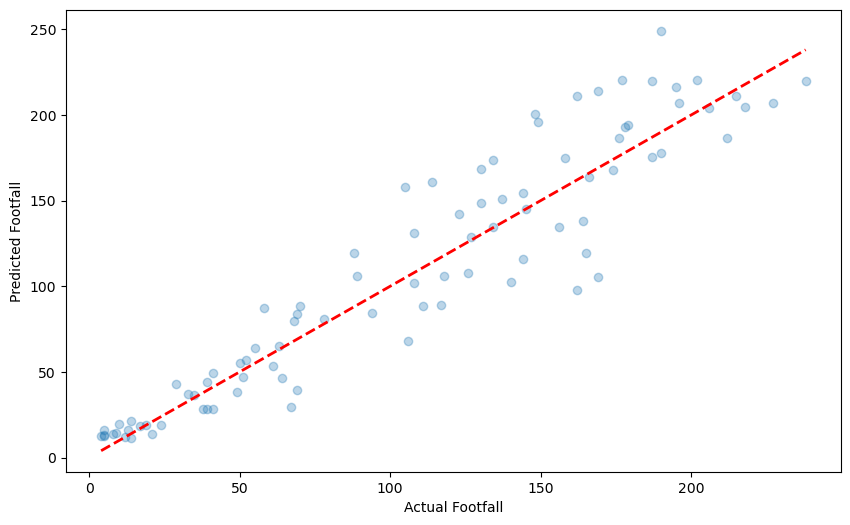


Performing analysis with full model (temperature, precipitation, TfL data - no aggregation and lag TFL) for Device 1833:
Mean Squared Error (Full Model - No Aggregation and Lag TFL) for Device 1833: 590.0374779112163


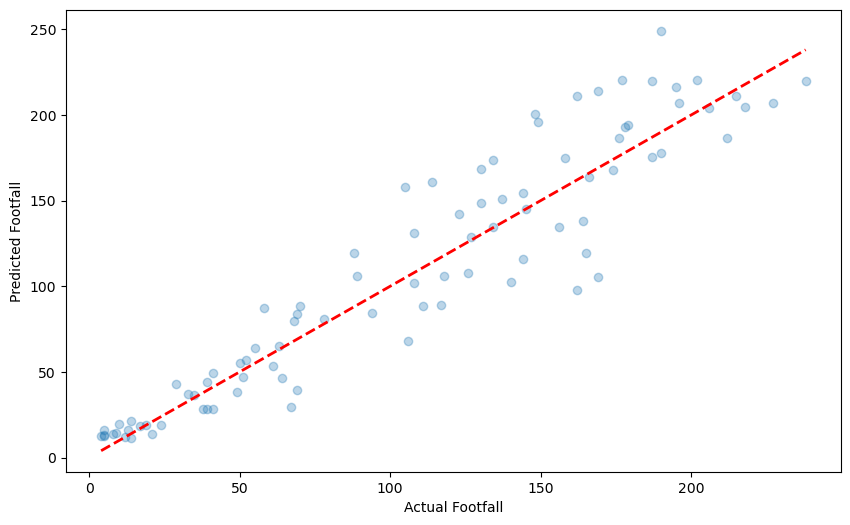

MSE values for all devices: {1018: 590.0374779112163, 1833: 590.0374779112163}


In [93]:
# Initialize dictionaries to store MSE values, predictions, and test data for each device
mse_full_no_agg_lagTFL_station = {}
y_test_full_no_agg_lagTFL_station = {}
y_pred_full_no_agg_lagTFL_station = {}

# Iterate over each device for individual analysis
for index, device_info in devices_near_station.iterrows():
    device_id = device_info['device']
    print(f"\nPerforming analysis with full model (temperature, precipitation, TfL data - no aggregation and lag TFL) for Device {device_id}:")

    # Ensure the 'date' column in both DataFrames is in datetime64[ns] format
    df_device_footfall_temp_prcp_no_aggregation['date'] = pd.to_datetime(df_device_footfall_temp_prcp_no_aggregation['date'])
    expanded_tfl_original_df['date'] = pd.to_datetime(expanded_tfl_original_df['date'])

    # Merge the device's footfall data with the TfL data
    df_device_full_model_no_agg = pd.merge(
        df_device_footfall_temp_prcp_no_aggregation,
        expanded_tfl_original_df[['date', 'start_time', 'end_time', 'count']],
        how='inner',
        left_on=['date', 'time'],
        right_on=['date', 'start_time']
    )

    # Create lag features for TfL data
    for lag in range(1, 25):
        df_device_full_model_no_agg[f'lag_tfl_{lag}'] = df_device_full_model_no_agg['count'].shift(lag)

    # Drop rows with NaNs introduced by the lagging
    df_device_full_model_no_agg.dropna(inplace=True)

    # Define features (X) including lag features, temperature, precipitation, and TfL data (count)
    X_full_no_agg_lagTFL_station = df_device_full_model_no_agg[
        [col for col in df_device_full_model_no_agg.columns if col.startswith('lag_')] + ['tavg', 'prcp', 'count']
    ]
    y_full_no_agg_lagTFL_station = df_device_full_model_no_agg['footfall']

    # Check that X and y have consistent lengths after dropping NaNs
    assert len(X_full_no_agg_lagTFL_station) == len(y_full_no_agg_lagTFL_station), \
        "X and y have inconsistent lengths after dropping NaNs."

    # Split the data into training and testing sets
    X_train_full_no_agg_lagTFL_station, X_test_full_no_agg_lagTFL_station, y_train_full_no_agg_lagTFL_station, y_test_full_no_agg_lagTFL_station = train_test_split(
        X_full_no_agg_lagTFL_station, y_full_no_agg_lagTFL_station, test_size=0.2, random_state=42, shuffle=False
    )

    # Train the model with footfall + temperature + precipitation + TfL data
    dtrain_full_no_agg_lagTFL_station = xgb.DMatrix(X_train_full_no_agg_lagTFL_station, label=y_train_full_no_agg_lagTFL_station)
    dtest_full_no_agg_lagTFL_station = xgb.DMatrix(X_test_full_no_agg_lagTFL_station, label=y_test_full_no_agg_lagTFL_station)

    # Train and predict using the XGBoost model
    bst_full_no_agg_lagTFL_station = xgb.train(params, dtrain_full_no_agg_lagTFL_station, num_boost_round=100)
    y_pred_full_no_agg_lagTFL_station[device_id] = bst_full_no_agg_lagTFL_station.predict(dtest_full_no_agg_lagTFL_station)

    # Calculate and store the Mean Squared Error
    mse_full_no_agg_lagTFL_station[device_id] = mean_squared_error(y_test_full_no_agg_lagTFL_station, y_pred_full_no_agg_lagTFL_station[device_id])
    print(f'Mean Squared Error (Full Model - No Aggregation and Lag TFL) for Device {device_id}: {mse_full_no_agg_lagTFL_station[device_id]}')

    # Visualize the results
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_full_no_agg_lagTFL_station, y_pred_full_no_agg_lagTFL_station[device_id], alpha=0.3)
    plt.plot([y_test_full_no_agg_lagTFL_station.min(), y_test_full_no_agg_lagTFL_station.max()], 
             [y_test_full_no_agg_lagTFL_station.min(), y_test_full_no_agg_lagTFL_station.max()], 'r--', lw=2)
    plt.xlabel('Actual Footfall')
    plt.ylabel('Predicted Footfall')

    plt.savefig(f'./figures/full_model_prediction_device_no_aggregation_lagTFL_{device_id}.png', bbox_inches='tight')

    plt.show()

# Print the dictionary with MSE values
print("MSE values for all devices:", mse_full_no_agg_lagTFL_station)

In [94]:
# Print the MSE values for devices with hourly-aggregated weather and TfL data
print("MSE values for all devices with hourly-aggregated weather and TfL data:", mse_full_hourly_agg_lagTFL_station)

# Print the MSE values for devices with non-aggregated weather and TfL data
print("MSE values for all devices with non-aggregated weather and TfL data:", mse_full_no_agg_lagTFL_station)

MSE values for all devices with hourly-aggregated weather and TfL data: {1018: 626.4828054891528, 1833: 626.4828054891528}
MSE values for all devices with non-aggregated weather and TfL data: {1018: 590.0374779112163, 1833: 590.0374779112163}


## 7.0 | Results


MSE Summary Across Models and Devices:
Device 1018 - Footfall Only - Mean Squared Error: 648.3081745412362
Device 1833 - Footfall Only - Mean Squared Error: 648.3081745412362
Device 1018 - Footfall + Temp (Hourly Aggregation) - Mean Squared Error: 1226.8604813324832
Device 1833 - Footfall + Temp (Hourly Aggregation) - Mean Squared Error: 1226.8604813324832
Device 1018 - Footfall + Temp (No Aggregation) - Mean Squared Error: 1250.67061443111
Device 1833 - Footfall + Temp (No Aggregation) - Mean Squared Error: 1250.67061443111
Device 1018 - Footfall + Temp + Prcp (Hourly Aggregation) - Mean Squared Error: 1226.8604813324832
Device 1833 - Footfall + Temp + Prcp (Hourly Aggregation) - Mean Squared Error: 1226.8604813324832
Device 1018 - Footfall + Temp + Prcp (No Aggregation) - Mean Squared Error: 1226.8604813324832
Device 1833 - Footfall + Temp + Prcp (No Aggregation) - Mean Squared Error: 1226.8604813324832
Device 1018 - Full Model (Hourly Aggregation) - Mean Squared Error: 626.48280548

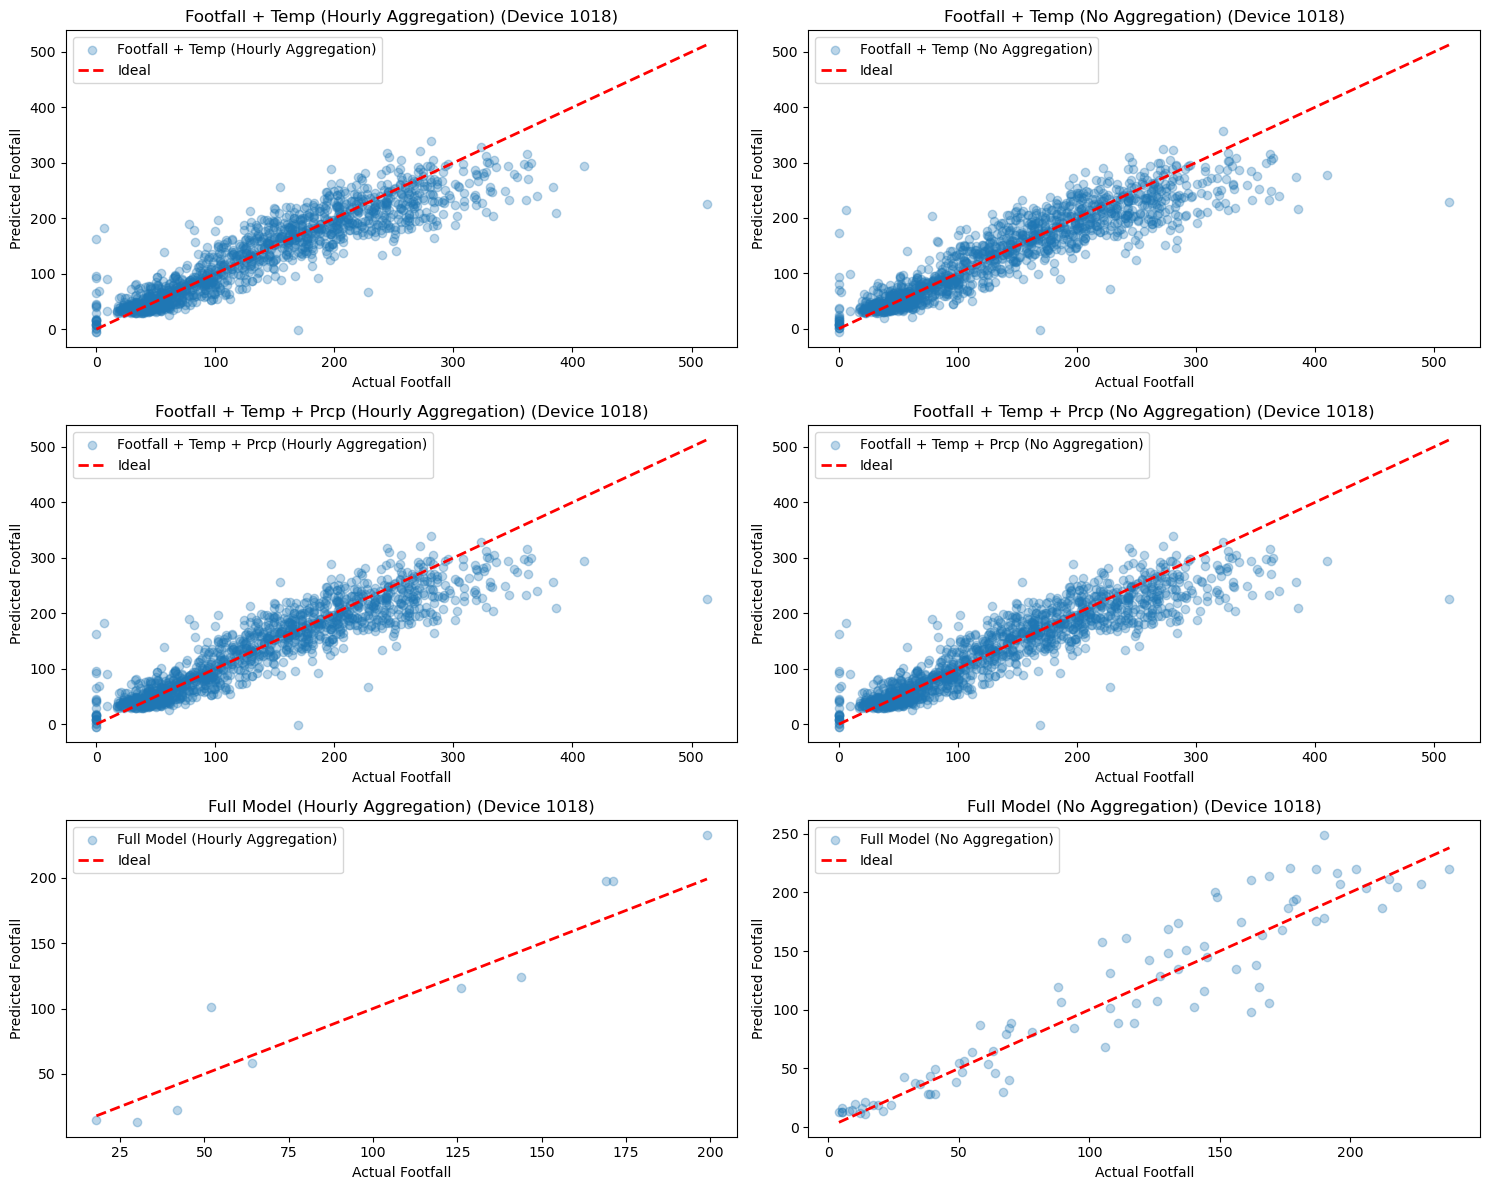

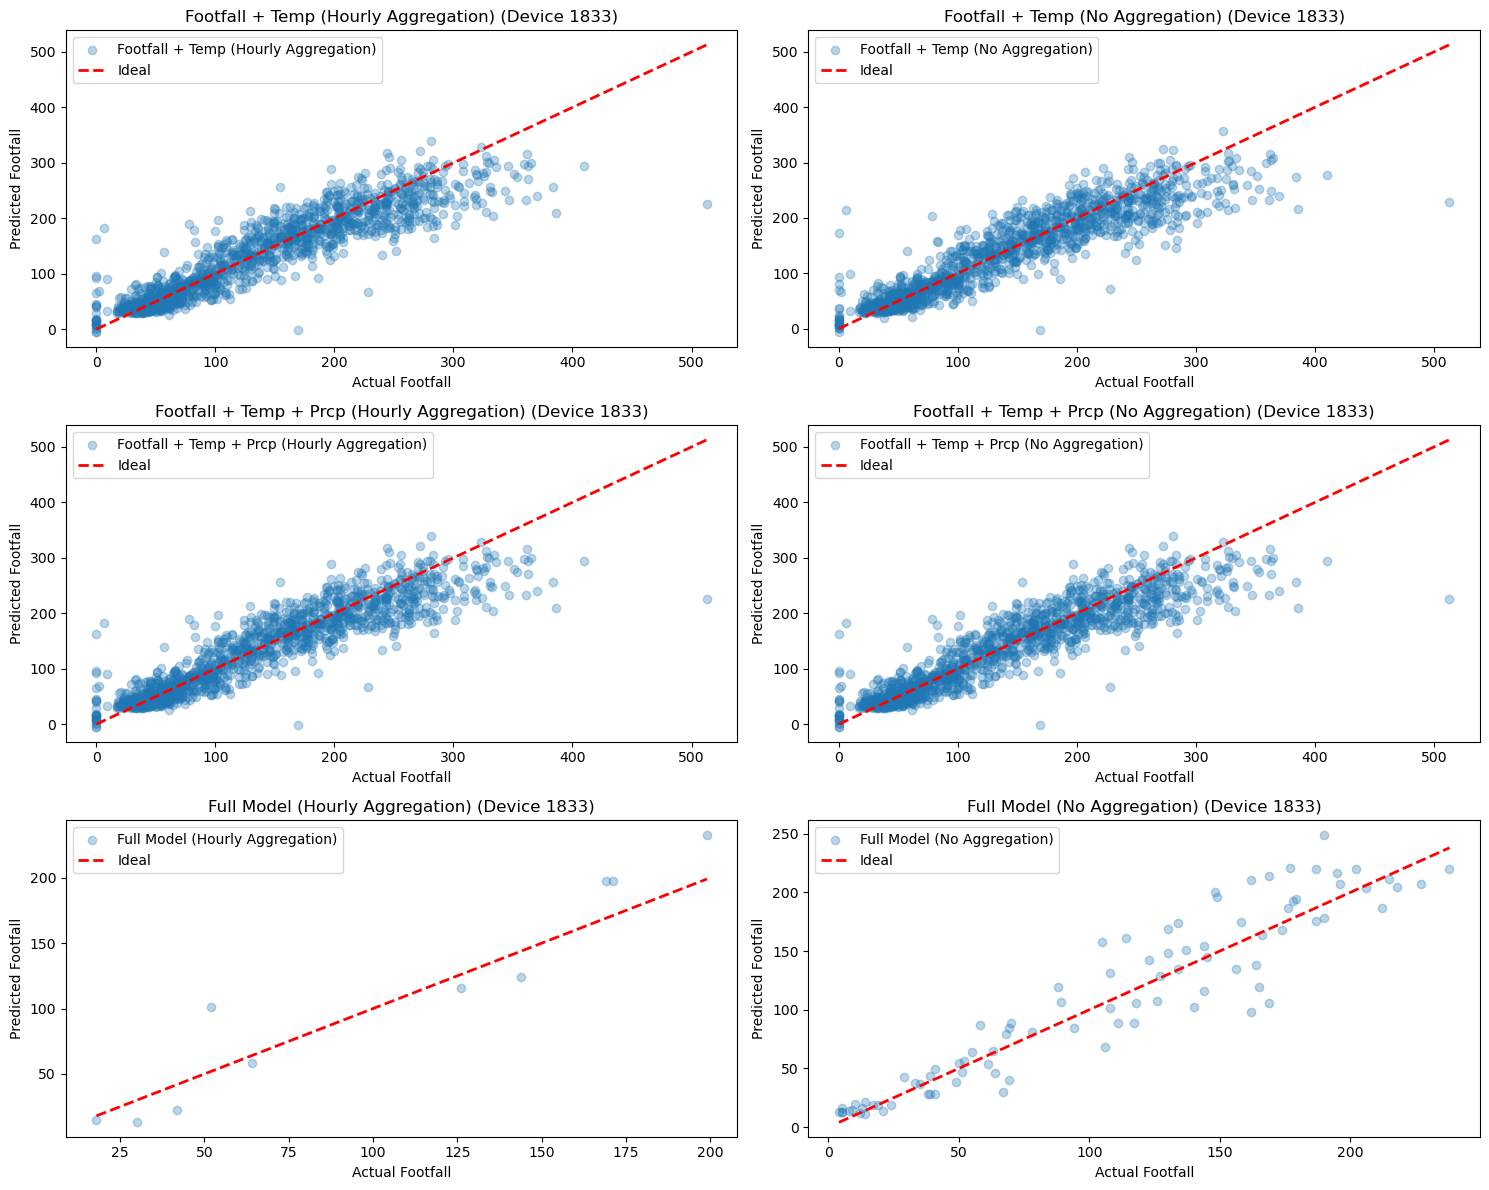

In [95]:
# Initialize the results dictionary to store MSE values and predictions for each model and device
results = {
    'Footfall Only': {'mse': {}, 'predictions': {}},
    'Footfall + Temp (Hourly Aggregation)': {'mse': {}, 'predictions': {}},
    'Footfall + Temp (No Aggregation)': {'mse': {}, 'predictions': {}},
    'Footfall + Temp + Prcp (Hourly Aggregation)': {'mse': {}, 'predictions': {}},
    'Footfall + Temp + Prcp (No Aggregation)': {'mse': {}, 'predictions': {}},
    'Full Model (Hourly Aggregation)': {'mse': {}, 'predictions': {}},
    'Full Model (No Aggregation)': {'mse': {}, 'predictions': {}}
}

# Iterate over each device and compute the results for each model
for index, device_info in devices_near_station.iterrows():
    device_id = device_info['device']

    # Footfall Only Model
    X_train_footfall, X_test_footfall, y_train_footfall, y_test_footfall = train_test_split(
        X_footfall_initial, y_footfall_initial, test_size=0.2, random_state=42, shuffle=False
    )
    dtrain_footfall = xgb.DMatrix(X_train_footfall, label=y_train_footfall)
    dtest_footfall = xgb.DMatrix(X_test_footfall, label=y_test_footfall)
    bst_footfall = xgb.train(params, dtrain_footfall, num_boost_round=100)
    y_pred_footfall = bst_footfall.predict(dtest_footfall)
    mse_footfall = mean_squared_error(y_test_footfall, y_pred_footfall)
    results['Footfall Only']['mse'][device_id] = mse_footfall
    results['Footfall Only']['predictions'][device_id] = (y_test_footfall, y_pred_footfall)

    # Footfall + Temperature (Hourly Aggregation)
    X_train_temp_hourly_agg, X_test_temp_hourly_agg, y_train_temp_hourly_agg, y_test_temp_hourly_agg = train_test_split(
        X_temp_prcp_initial, y_temp_prcp_initial, test_size=0.2, random_state=42, shuffle=False
    )
    dtrain_temp_hourly_agg = xgb.DMatrix(X_train_temp_hourly_agg, label=y_train_temp_hourly_agg)
    dtest_temp_hourly_agg = xgb.DMatrix(X_test_temp_hourly_agg, label=y_test_temp_hourly_agg)
    bst_temp_hourly_agg = xgb.train(params, dtrain_temp_hourly_agg, num_boost_round=100)
    y_pred_temp_hourly_agg = bst_temp_hourly_agg.predict(dtest_temp_hourly_agg)
    mse_temp_hourly_agg = mean_squared_error(y_test_temp_hourly_agg, y_pred_temp_hourly_agg)
    results['Footfall + Temp (Hourly Aggregation)']['mse'][device_id] = mse_temp_hourly_agg
    results['Footfall + Temp (Hourly Aggregation)']['predictions'][device_id] = (y_test_temp_hourly_agg, y_pred_temp_hourly_agg)

    # Footfall + Temperature (No Aggregation)
    X_train_temp_no_agg, X_test_temp_no_agg, y_train_temp_no_agg, y_test_temp_no_agg = train_test_split(
        X_temp_initial, y_temp_initial, test_size=0.2, random_state=42, shuffle=False
    )
    dtrain_temp_no_agg = xgb.DMatrix(X_train_temp_no_agg, label=y_train_temp_no_agg)
    dtest_temp_no_agg = xgb.DMatrix(X_test_temp_no_agg, label=y_test_temp_no_agg)
    bst_temp_no_agg = xgb.train(params, dtrain_temp_no_agg, num_boost_round=100)
    y_pred_temp_no_agg = bst_temp_no_agg.predict(dtest_temp_no_agg)
    mse_temp_no_agg = mean_squared_error(y_test_temp_no_agg, y_pred_temp_no_agg)
    results['Footfall + Temp (No Aggregation)']['mse'][device_id] = mse_temp_no_agg
    results['Footfall + Temp (No Aggregation)']['predictions'][device_id] = (y_test_temp_no_agg, y_pred_temp_no_agg)

    # Footfall + Temp + Prcp (Hourly Aggregation)
    X_train_temp_prcp_hourly_agg, X_test_temp_prcp_hourly_agg, y_train_temp_prcp_hourly_agg, y_test_temp_prcp_hourly_agg = train_test_split(
        X_temp_prcp_initial, y_temp_prcp_initial, test_size=0.2, random_state=42, shuffle=False
    )
    dtrain_temp_prcp_hourly_agg = xgb.DMatrix(X_train_temp_prcp_hourly_agg, label=y_train_temp_prcp_hourly_agg)
    dtest_temp_prcp_hourly_agg = xgb.DMatrix(X_test_temp_prcp_hourly_agg, label=y_test_temp_prcp_hourly_agg)
    bst_temp_prcp_hourly_agg = xgb.train(params, dtrain_temp_prcp_hourly_agg, num_boost_round=100)
    y_pred_temp_prcp_hourly_agg = bst_temp_prcp_hourly_agg.predict(dtest_temp_prcp_hourly_agg)
    mse_temp_prcp_hourly_agg = mean_squared_error(y_test_temp_prcp_hourly_agg, y_pred_temp_prcp_hourly_agg)
    results['Footfall + Temp + Prcp (Hourly Aggregation)']['mse'][device_id] = mse_temp_prcp_hourly_agg
    results['Footfall + Temp + Prcp (Hourly Aggregation)']['predictions'][device_id] = (y_test_temp_prcp_hourly_agg, y_pred_temp_prcp_hourly_agg)

    # Footfall + Temp + Prcp (No Aggregation)
    X_train_temp_prcp_no_agg, X_test_temp_prcp_no_agg, y_train_temp_prcp_no_agg, y_test_temp_prcp_no_agg = train_test_split(
        X_temp_prcp_initial, y_temp_prcp_initial, test_size=0.2, random_state=42, shuffle=False
    )
    dtrain_temp_prcp_no_agg = xgb.DMatrix(X_train_temp_prcp_no_agg, label=y_train_temp_prcp_no_agg)
    dtest_temp_prcp_no_agg = xgb.DMatrix(X_test_temp_prcp_no_agg, label=y_test_temp_prcp_no_agg)
    bst_temp_prcp_no_agg = xgb.train(params, dtrain_temp_prcp_no_agg, num_boost_round=100)
    y_pred_temp_prcp_no_agg = bst_temp_prcp_no_agg.predict(dtest_temp_prcp_no_agg)
    mse_temp_prcp_no_agg = mean_squared_error(y_test_temp_prcp_no_agg, y_pred_temp_prcp_no_agg)
    results['Footfall + Temp + Prcp (No Aggregation)']['mse'][device_id] = mse_temp_prcp_no_agg
    results['Footfall + Temp + Prcp (No Aggregation)']['predictions'][device_id] = (y_test_temp_prcp_no_agg, y_pred_temp_prcp_no_agg)

    # Full Model (Hourly Aggregation)
    X_train_full_hourly_agg_lagTFL, X_test_full_hourly_agg_lagTFL, y_train_full_hourly_agg_lagTFL, y_test_full_hourly_agg_lagTFL = train_test_split(
        X_full_hourly_agg_lagTFL_station, y_full_hourly_agg_lagTFL_station, test_size=0.2, random_state=42, shuffle=False
    )
    dtrain_full_hourly_agg_lagTFL = xgb.DMatrix(X_train_full_hourly_agg_lagTFL, label=y_train_full_hourly_agg_lagTFL)
    dtest_full_hourly_agg_lagTFL = xgb.DMatrix(X_test_full_hourly_agg_lagTFL, label=y_test_full_hourly_agg_lagTFL)
    bst_full_hourly_agg_lagTFL = xgb.train(params, dtrain_full_hourly_agg_lagTFL, num_boost_round=100)
    y_pred_full_hourly_agg_lagTFL = bst_full_hourly_agg_lagTFL.predict(dtest_full_hourly_agg_lagTFL)
    mse_full_hourly_agg_lagTFL = mean_squared_error(y_test_full_hourly_agg_lagTFL, y_pred_full_hourly_agg_lagTFL)
    results['Full Model (Hourly Aggregation)']['mse'][device_id] = mse_full_hourly_agg_lagTFL
    results['Full Model (Hourly Aggregation)']['predictions'][device_id] = (y_test_full_hourly_agg_lagTFL, y_pred_full_hourly_agg_lagTFL)

    # Full Model (No Aggregation)
    X_train_full_no_agg_lagTFL, X_test_full_no_agg_lagTFL, y_train_full_no_agg_lagTFL, y_test_full_no_agg_lagTFL = train_test_split(
        X_full_no_agg_lagTFL_station, y_full_no_agg_lagTFL_station, test_size=0.2, random_state=42, shuffle=False
    )
    dtrain_full_no_agg_lagTFL = xgb.DMatrix(X_train_full_no_agg_lagTFL, label=y_train_full_no_agg_lagTFL)
    dtest_full_no_agg_lagTFL = xgb.DMatrix(X_test_full_no_agg_lagTFL, label=y_test_full_no_agg_lagTFL)
    bst_full_no_agg_lagTFL = xgb.train(params, dtrain_full_no_agg_lagTFL, num_boost_round=100)
    y_pred_full_no_agg_lagTFL = bst_full_no_agg_lagTFL.predict(dtest_full_no_agg_lagTFL)
    mse_full_no_agg_lagTFL = mean_squared_error(y_test_full_no_agg_lagTFL, y_pred_full_no_agg_lagTFL)
    results['Full Model (No Aggregation)']['mse'][device_id] = mse_full_no_agg_lagTFL
    results['Full Model (No Aggregation)']['predictions'][device_id] = (y_test_full_no_agg_lagTFL, y_pred_full_no_agg_lagTFL)

# Summarize MSE for all models across all devices
print("\nMSE Summary Across Models and Devices:")
for model_name, model_results in results.items():
    for device_id, mse in model_results['mse'].items():
        print(f"Device {device_id} - {model_name} - Mean Squared Error: {mse}")

# Visualize Actual vs Predicted Footfall for Each Model and Device (Excluding Footfall Only)
for device_id in devices_near_station['device']:
    plt.figure(figsize=(15, 12))
    model_names = [name for name in results.keys() if name != 'Footfall Only']
    for i, model_name in enumerate(model_names, start=1):
        y_test, y_pred = results[model_name]['predictions'][device_id]
        plt.subplot(3, 2, i)  # Change to 3 rows and 2 columns
        plt.scatter(y_test, y_pred, alpha=0.3, label=f'{model_name}')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2, label='Ideal')
        plt.xlabel('Actual Footfall')
        plt.ylabel('Predicted Footfall')
        plt.title(f'{model_name} (Device {device_id})')
        plt.legend()

    plt.tight_layout()
    plt.savefig(f'./figures/actual_vs_predicted_comparison_across_models_device_{device_id}.png', bbox_inches='tight')
    plt.show()